In [1]:
import numpy as np
import scipy as ci 
import pandas as pd 
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
from scipy.optimize import curve_fit
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.gridspec as gridspec
from IPython.display import display, HTML
from matplotlib.colors import LogNorm

import seaborn as sns 
import tables 
import pickle
import warnings
import iminuit as mi
from scipy.integrate import quad, dblquad
from scipy.interpolate import interp1d
warnings.filterwarnings(action='once')

%matplotlib inline 
%config InlineBackend.figure_format = 'retina'

In [2]:
plt.figure()
plt.rcParams['figure.facecolor'] = 'white'
plt.rcParams.update({'font.size': 12})
plt.rc('axes', axisbelow=True)

<Figure size 432x288 with 0 Axes>

In [3]:
lifetime = 86400*365 # 1 year! 
fig_dir = '/Users/yang/Desktop/IceCube/Codes/my_proj/analysis_1_downgoing_neutrino/1_distribution_plots/plots/ana-3-1-'
data_dir = '/Users/yang/Desktop/IceCube/Codes/my_proj/analysis_1_downgoing_neutrino/data/'

/Users/yang/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:13: RuntimeWarning: invalid value encountered in sqrt
  del sys.path[0]
/Users/yang/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:13: RuntimeWarning: invalid value encountered in greater
  del sys.path[0]


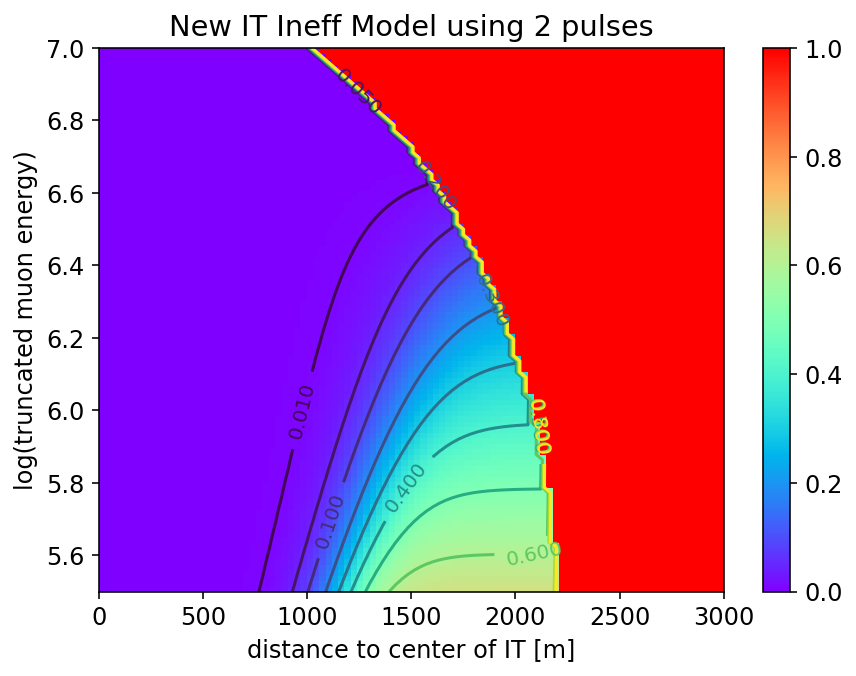

In [4]:
# OLD and NEW ineff model parameters 
params_new = np.loadtxt('/Users/yang/Desktop/IceCube/Codes/my_proj/analysis_1_downgoing_neutrino/1_distribution_plots/IT_model.txt')
def ineff_model_new(dist,E): # E: log10 of energy!!! 

    a = params_new[0] + params_new[1]*E #* (E + params_new[1])**2
    b = params_new[2] + params_new[3]*E
    c = params_new[4] + params_new[5]*E
    val = a * 1 / (1+np.exp(-100*(dist/2000-b)*c))

    val[val < 1e-5] = 1e-5 # This is arbitrary! 

    # low stat cut 
    val[E > 5.4+1.8*np.sqrt(1 - (dist)**2/2200**2)]=1
    val[dist>2200]=1
#     val[E<4.7]=0.7
#     val[E<3/500*dist + 3-3/500*200]=0.7
    return val

xt = np.linspace(0.001,3000,100) # dist 
yt = np.linspace(5.5,7,100)  # E 
xg,yg = np.meshgrid(xt,yt)
zg = ineff_model_new(xg,yg)

plt.figure(figsize=(7,5))
plt.rcParams.update({'font.size': 12})
plt.rc('axes', axisbelow=True)
plt.pcolormesh(xg,yg,zg,cmap='rainbow',shading='flat')
plt.colorbar()
plt.clim(0,1) # colorbar limit
CS=plt.contour(xg,yg,zg,levels=[0.01,0.05,0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8])
plt.clabel(CS,inline=1,fmt='%1.3f',fontsize=10)
plt.xlabel('distance to center of IT [m]')
plt.ylabel('log(truncated muon energy)')
plt.xlim(0,3000)
plt.ylim(5.5,7)
plt.title('New IT Ineff Model using 2 pulses')
plt.show()

In [5]:
with tables.open_file(data_dir+'corsika_h5/corsika_combined.h5','r') as f:

    ineff_ = ineff_model_new(f.root.Dist_to_IT_center.cols.value[:],np.log10(f.root.SplineMPETruncatedEnergy_SPICEMie_BINS_Muon.cols.energy[:]))

    CUT_dedx = f.root.Collection.cols.len_dEdxVector[:] >= 6
    CUT_cascllh = f.root.CascadeLlhVertexFitParams.cols.rlogL[:] < 18
    CUT_d_IC = f.root.Dist_to_IC_center.cols.value[:] < 450
    CUT_LdirC = f.root.SplineMPEDirectHitsC.cols.dir_track_length[:] > 600
    CUT_balloon = f.root.Balloon.cols.InIceBalloonParameter[:] < 0.22
    CUT_ineff = ineff_ < 0.01
    
    CUT_SIGNAL = np.log10(f.root.Collection.cols.chi2_red_new[:]) > -10#2.5
    
    CUT_goodweight = f.root.Combined_Weight_H3a[:] > 0
    
    CUT = CUT_dedx & CUT_cascllh & CUT_d_IC & CUT_LdirC & CUT_balloon & CUT_ineff & CUT_goodweight & CUT_SIGNAL
    
    chi2_corsika = f.root.Collection.cols.chi2[:][CUT]
    chi2_red_corsika = f.root.Collection.cols.chi2_red[:][CUT]
    stoch_corsika = f.root.Collection.cols.stoch[:][CUT]
    chi2_new_corsika = f.root.Collection.cols.chi2_new[:][CUT]
    chi2_red_new_corsika = f.root.Collection.cols.chi2_red_new[:][CUT]
    PeakOverMedian_corsika = f.root.Collection.cols.PeakOverMedian[:][CUT]
    PeakOverMean_corsika = f.root.Collection.cols.PeakOverMean[:][CUT]

    zenith_corsika = f.root.SplineMPE.cols.zenith[:][CUT]
    truncated_muon_e_corsika = f.root.SplineMPETruncatedEnergy_SPICEMie_BINS_Muon.cols.energy[:][CUT]
    len_dedx_corsika = f.root.Collection.cols.len_dEdxVector[:][CUT]
    cascllh_corsika = f.root.CascadeLlhVertexFitParams.cols.rlogL[:][CUT]
    NPE_corsika = f.root.QTot.cols.value[:][CUT]
    Qtot_corsika = f.root.Balloon.cols.InIceTotalCharge[:][CUT]
    N_dom_corsika = f.root.Balloon.cols.N_Doms[:][CUT]
    N_pulses_corsika = f.root.Balloon.cols.N_Pulses[:][CUT]
    balloon_corsika = f.root.Balloon.cols.InIceBalloonParameter[:][CUT]
    balloon_adjusted_corsika = f.root.Balloon.cols.InIceBalloonParameter_adjusted[:][CUT]
    in_ice_total_charge_corsika = f.root.Balloon.cols.InIceTotalCharge[:][CUT]
    in_ice_total_charge_reduced_corsika = f.root.Balloon.cols.InIceTotalCharge_reduced[:][CUT]
    ndirdoms_corsika = f.root.SplineMPEDirectHitsC.cols.n_dir_doms[:][CUT]
    ndirpulses_corsika = f.root.SplineMPEDirectHitsC.cols.n_dir_pulses[:][CUT]
    topocount_corsika = f.root.TologicalCounterSplitCount.cols.value[:][CUT]
    wimpcount_corsika = f.root.WIMPrecoTopoSplitSplitCount.cols.value[:][CUT]
    cv_ndoms_corsika = f.root.CVMultiplicity.cols.n_hit_doms[:][CUT]
    cv_npulses_corsika = f.root.CVMultiplicity.cols.n_pulses[:][CUT]
    
    closest_d_corsika = f.root.Closest_approach_dist_to_nearest_IT_dom.cols.value[:][CUT]
    d_to_IC_center_corsika = f.root.Dist_to_IC_center.cols.value[:][CUT]
    d_to_IT_center_corsika = f.root.Dist_to_IT_center.cols.value[:][CUT]
    Ldir_corsika = f.root.SplineMPEDirectHitsC.cols.dir_track_length[:][CUT]
#     coincident_corsika = f.root.MCPrimary_coincident.cols.value[:][CUT]
    prim_e_corsika = f.root.PolyplopiaPrimary.cols.energy[:][CUT]
    
    E_bundle_corsika = f.root.Bundle.cols.MuonBundleEnergy_Ei[:][CUT]
    E_leading_muon_corsika = f.root.Bundle.cols.MostEnergeticMuonEnergy_i[:][CUT]
    singleness_corsika = f.root.Bundle.cols.Singleness_Ei[:][CUT]
    bsize_corsika = f.root.Bundle.cols.Size_Ei[:][CUT]
    xf_corsika = E_bundle_corsika/prim_e_corsika
    E_shower_corsika = prim_e_corsika - E_bundle_corsika # surface shower
    
    runid_corsika = f.root.FileNumber.cols.value[:][CUT]
    eventid_corsika = f.root.FileNumber.cols.Event[:][CUT]
    
    A_corsika = f.root.PolyplopiaPrimary.cols.type[:][CUT]

    weight_corsika = f.root.Combined_Weight_H3a[:][CUT] * lifetime * ineff_[CUT]

/Users/yang/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:13: RuntimeWarning: invalid value encountered in sqrt
  del sys.path[0]
/Users/yang/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:13: RuntimeWarning: invalid value encountered in greater
  del sys.path[0]


In [6]:
with tables.open_file(data_dir+'nugen_h5/nugen_20878.h5','r') as f:
    n_file = 10000

    ineff_ = ineff_model_new(f.root.Dist_to_IT_center.cols.value[:],np.log10(f.root.SplineMPETruncatedEnergy_SPICEMie_BINS_Muon.cols.energy[:]))

    CUT_dedx = f.root.Collection.cols.len_dEdxVector[:] >= 6
    CUT_cascllh = f.root.CascadeLlhVertexFitParams.cols.rlogL[:] < 18
    CUT_d_IC = f.root.Dist_to_IC_center.cols.value[:] < 450
    CUT_LdirC = f.root.SplineMPEDirectHitsC.cols.dir_track_length[:] > 600
    CUT_balloon = f.root.Balloon.cols.InIceBalloonParameter[:] < 0.22
    CUT_ineff = ineff_ < 0.01
    
    CUT_SIGNAL = np.log10(f.root.Collection.cols.chi2_red_new[:]) > -10#2.5

    CUT = CUT_dedx & CUT_cascllh & CUT_d_IC & CUT_LdirC & CUT_balloon & CUT_ineff & CUT_SIGNAL
    
    chi2_numu = f.root.Collection.cols.chi2[:][CUT]
    chi2_red_numu = f.root.Collection.cols.chi2_red[:][CUT]
    stoch_numu = f.root.Collection.cols.stoch[:][CUT]
    chi2_new_numu = f.root.Collection.cols.chi2_new[:][CUT]
    chi2_red_new_numu = f.root.Collection.cols.chi2_red_new[:][CUT]
    PeakOverMedian_numu = f.root.Collection.cols.PeakOverMedian[:][CUT]
    PeakOverMean_numu = f.root.Collection.cols.PeakOverMean[:][CUT]

    zenith_numu = f.root.SplineMPE.cols.zenith[:][CUT]
    truncated_muon_e_numu = f.root.SplineMPETruncatedEnergy_SPICEMie_BINS_Muon.cols.energy[:][CUT]
    len_dedx_numu = f.root.Collection.cols.len_dEdxVector[:][CUT]
    cascllh_numu = f.root.CascadeLlhVertexFitParams.cols.rlogL[:][CUT]
    NPE_numu = f.root.QTot.cols.value[:][CUT]
    Qtot_numu = f.root.Balloon.cols.InIceTotalCharge[:][CUT]
    N_dom_numu = f.root.Balloon.cols.N_Doms[:][CUT]
    N_pulses_numu = f.root.Balloon.cols.N_Pulses[:][CUT]
    balloon_numu = f.root.Balloon.cols.InIceBalloonParameter[:][CUT]
    balloon_adjusted_numu = f.root.Balloon.cols.InIceBalloonParameter_adjusted[:][CUT]
    in_ice_total_charge_numu = f.root.Balloon.cols.InIceTotalCharge[:][CUT]
    in_ice_total_charge_reduced_numu = f.root.Balloon.cols.InIceTotalCharge_reduced[:][CUT]
    ndirdoms_numu = f.root.SplineMPEDirectHitsC.cols.n_dir_doms[:][CUT]
    ndirpulses_numu = f.root.SplineMPEDirectHitsC.cols.n_dir_pulses[:][CUT]
    topocount_numu = f.root.TologicalCounterSplitCount.cols.value[:][CUT]
    wimpcount_numu = f.root.WIMPrecoTopoSplitSplitCount.cols.value[:][CUT]
    cv_ndoms_numu = f.root.CVMultiplicity.cols.n_hit_doms[:][CUT]
    cv_npulses_numu = f.root.CVMultiplicity.cols.n_pulses[:][CUT]
    
    closest_d_numu = f.root.Closest_approach_dist_to_nearest_IT_dom.cols.value[:][CUT]
    d_to_IC_center_numu = f.root.Dist_to_IC_center.cols.value[:][CUT]
    d_to_IT_center_numu = f.root.Dist_to_IT_center.cols.value[:][CUT]
    Ldir_numu = f.root.SplineMPEDirectHitsC.cols.dir_track_length[:][CUT]
#     coincident_numu = f.root.MCPrimary_coincident.cols.value[:][CUT]
    prim_e_numu = f.root.PolyplopiaPrimary.cols.energy[:][CUT]
    
    # astrophysical #
    energy = f.root.PolyplopiaPrimary.cols.energy[:][CUT]
    OneWeight = f.root.I3MCWeightDict.cols.OneWeight[:][CUT]
    NEvents = f.root.I3MCWeightDict.cols.NEvents[:][CUT]
    weight_numu_astro = (6.7 * 10**(-18))/6 * (energy/10**5)**(-2) * OneWeight/(n_file * NEvents) * lifetime * 2  # 10**5: 100 TeV. 2 is nu+nubar
    
    # atmospheric 
    
    weight_numu_conv = f.root.weight_honda2006[:][CUT] * lifetime/n_file 
    weight_numu_prompt = f.root.weight_BERSS_H3p_central[:][CUT] * lifetime/n_file 
    

/Users/yang/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:13: RuntimeWarning: invalid value encountered in sqrt
  del sys.path[0]
/Users/yang/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:13: RuntimeWarning: invalid value encountered in greater
  del sys.path[0]


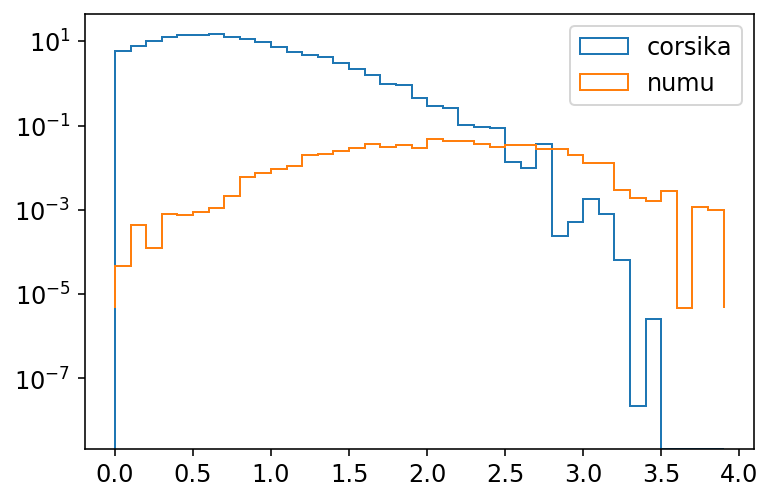

In [7]:
plt.hist(np.log10(chi2_red_new_corsika),weights=weight_corsika,histtype='step',log=True,bins=np.arange(0,4,0.1),label='corsika')
plt.hist(np.log10(chi2_red_new_numu),weights=weight_numu_astro,histtype='step',log=True,bins=np.arange(0,4,0.1),label='numu')
plt.legend()
plt.show()

In [8]:
# effective area 
areas =  OneWeight/(n_file * NEvents) * 2  # or: 1./gen * p_int / n_file / unit 
neutrino_energy_my = np.logspace(5, 8, 50)
binwidth = 4*np.pi*np.diff(neutrino_energy_my)
effective_area_numu_my = np.histogram(prim_e_numu, weights=areas, bins=neutrino_energy_my)[0]/binwidth
neutrino_energy_my = (neutrino_energy_my[1:]+neutrino_energy_my[:-1])/2

/Users/yang/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1: RuntimeWarning: divide by zero encountered in log10
  """Entry point for launching an IPython kernel.


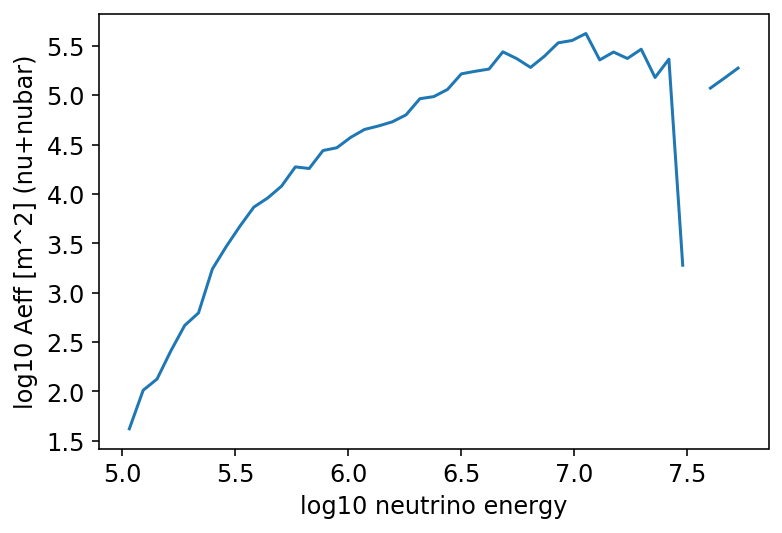

In [9]:
plt.plot(np.log10(neutrino_energy_my),np.log10(effective_area_numu_my))
plt.xlabel('log10 neutrino energy')
plt.ylabel('log10 Aeff [m^2] (nu+nubar)')
plt.show()

In [10]:
N = 10
energy_bin = np.linspace(5.5,7.5,N)
zenith_bin = np.linspace(0,1,N)

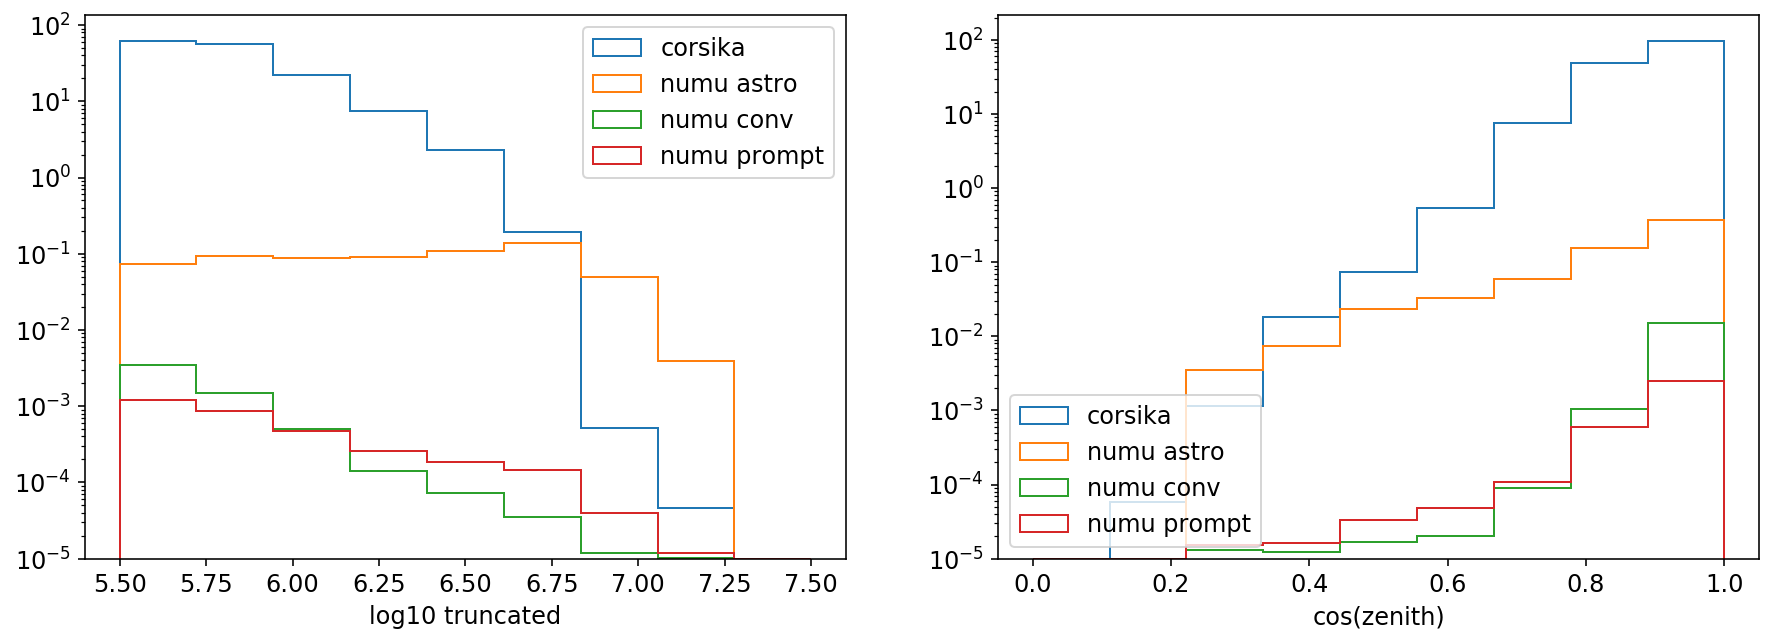

In [11]:
plt.figure(figsize=(15,5))
plt.subplot(121)
plt.hist(np.log10(truncated_muon_e_corsika),weights=weight_corsika,bins=energy_bin,histtype='step',label='corsika',log=True,bottom=1e-5)
plt.hist(np.log10(truncated_muon_e_numu),weights=weight_numu_astro,bins=energy_bin,histtype='step',label='numu astro',log=True,bottom=1e-5)
plt.hist(np.log10(truncated_muon_e_numu),weights=weight_numu_conv,bins=energy_bin,histtype='step',label='numu conv',log=True,bottom=1e-5)
plt.hist(np.log10(truncated_muon_e_numu),weights=weight_numu_prompt,bins=energy_bin,histtype='step',label='numu prompt',log=True,bottom=1e-5)

plt.legend()
plt.xlabel('log10 truncated')
plt.subplot(122)
plt.hist(np.cos(zenith_corsika),weights=weight_corsika,bins=zenith_bin,histtype='step',label='corsika',log=True,bottom=1e-5)
plt.hist(np.cos(zenith_numu),weights=weight_numu_astro,bins=zenith_bin,histtype='step',label='numu astro',log=True,bottom=1e-5)
plt.hist(np.cos(zenith_numu),weights=weight_numu_conv,bins=zenith_bin,histtype='step',label='numu conv',log=True,bottom=1e-5)
plt.hist(np.cos(zenith_numu),weights=weight_numu_prompt,bins=zenith_bin,histtype='step',label='numu prompt',log=True,bottom=1e-5)

plt.legend(loc='lower left')
plt.xlabel('cos(zenith)')
plt.show()

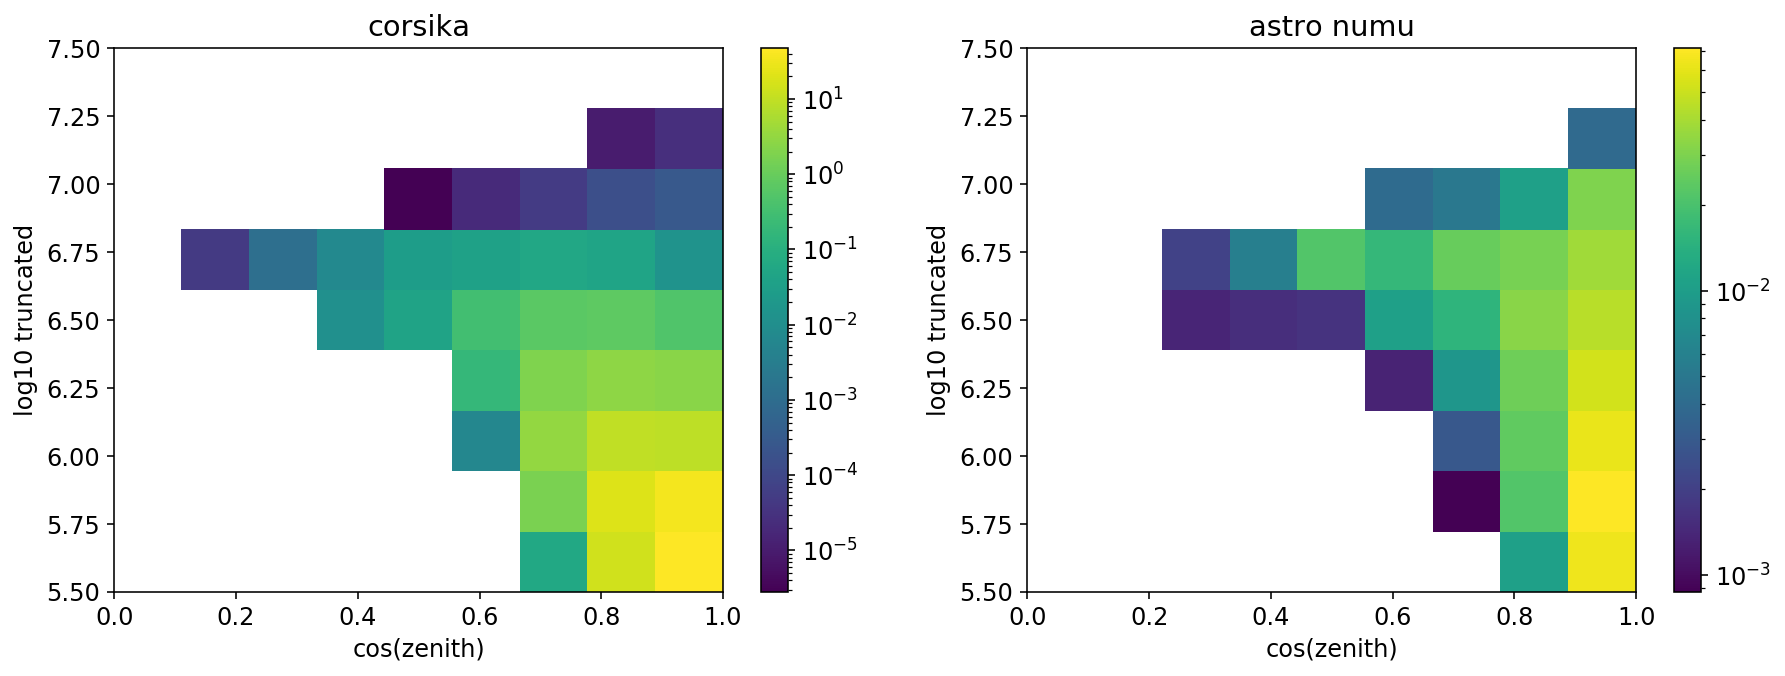

In [12]:
plt.figure(figsize=(15,5))
plt.subplot(121)
plt.hist2d(np.cos(zenith_corsika),np.log10(truncated_muon_e_corsika),weights=weight_corsika,bins=[zenith_bin,energy_bin],norm=matplotlib.colors.LogNorm())
plt.xlabel('cos(zenith)')
plt.ylabel('log10 truncated')
plt.title('corsika')
plt.colorbar()
plt.subplot(122)
plt.hist2d(np.cos(zenith_numu),np.log10(truncated_muon_e_numu),weights=weight_numu_astro,bins=[zenith_bin,energy_bin],norm=matplotlib.colors.LogNorm())
plt.xlabel('cos(zenith)')
plt.ylabel('log10 truncated')
plt.title('astro numu')
plt.colorbar()
plt.show()

# 1. Estimating astro norm, spectral idx

In [14]:
def astro_weight(norm,gamma):
    return norm * 1e-18 * (prim_e_numu/1e5)**(-gamma) * OneWeight/(n_file * NEvents) * lifetime * 2

In [15]:
def llh(norm,gamma): # - log likelihood 
    # 'observed data'
    h_corsika_observed, _,_ = np.histogram2d(np.cos(zenith_corsika),np.log10(truncated_muon_e_corsika),weights=weight_corsika,bins=[zenith_bin,energy_bin])
    h_numu_astro_observed, _,_ = np.histogram2d(np.cos(zenith_numu),np.log10(truncated_muon_e_numu),weights=weight_numu_astro,bins=[zenith_bin,energy_bin])
    h_numu_conv_observed, _,_ = np.histogram2d(np.cos(zenith_numu),np.log10(truncated_muon_e_numu),weights=weight_numu_conv,bins=[zenith_bin,energy_bin])
    h_numu_prompt_observed, _,_ = np.histogram2d(np.cos(zenith_numu),np.log10(truncated_muon_e_numu),weights=weight_numu_prompt,bins=[zenith_bin,energy_bin])

    h_observed = h_corsika_observed + h_numu_astro_observed #+ h_numu_conv_observed + h_numu_prompt_observed
    
    # expected under assumed norm, gamma
    h_corsika, _,_ = np.histogram2d(np.cos(zenith_corsika),np.log10(truncated_muon_e_corsika),weights=weight_corsika,bins=[zenith_bin,energy_bin])
    h_numu_astro, _,_ = np.histogram2d(np.cos(zenith_numu),np.log10(truncated_muon_e_numu),weights=astro_weight(norm,gamma),bins=[zenith_bin,energy_bin])
    h_numu_conv, _,_ = np.histogram2d(np.cos(zenith_numu),np.log10(truncated_muon_e_numu),weights=weight_numu_conv,bins=[zenith_bin,energy_bin])
    h_numu_prompt, _,_ = np.histogram2d(np.cos(zenith_numu),np.log10(truncated_muon_e_numu),weights=weight_numu_prompt,bins=[zenith_bin,energy_bin])
    
    h_expected = h_corsika + h_numu_astro #+ h_numu_conv + h_numu_prompt
    
    # log likelihood = sum over bind ( k * log(lam) - lam - logGamma(k+1) )

    llh = h_observed * np.log(h_expected) - h_expected + h_observed*np.log(h_observed) - h_observed #ci.special.loggamma(h_observed+1)
    llh[(h_observed==0)&(h_expected==0)] = 0
    
    return np.sum(llh)
def negllh(norm,gamma):
    return - llh(norm,gamma)

In [16]:
m = mi.Minuit(negllh,norm=1,gamma=2.,errordef=mi.Minuit.LIKELIHOOD,limit_norm=(0.01,10),limit_gamma=(0.01,3))

In [17]:
m.migrad()

/Users/yang/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:20: RuntimeWarning: divide by zero encountered in log
/Users/yang/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:20: RuntimeWarning: invalid value encountered in multiply


------------------------------------------------------------------
| FCN = -611.8                  |      Ncalls=29 (29 total)      |
| EDM = 9.33e-07 (Goal: 0.0001) |            up = 0.5            |
------------------------------------------------------------------
|  Valid Min.   | Valid Param.  | Above EDM | Reached call limit |
------------------------------------------------------------------
|     True      |     True      |   False   |       False        |
------------------------------------------------------------------
| Hesse failed  |   Has cov.    | Accurate  | Pos. def. | Forced |
------------------------------------------------------------------
|     False     |     True      |   True    |   True    | False  |
------------------------------------------------------------------
-------------------------------------------------------------------------------------------
|   | Name  |   Value   | Hesse Err | Minos Err- | Minos Err+ | Limit-  | Limit+  | Fixed |
-------------------------------------------------------------------------------------------
| 0 | norm  |     1     |     9     |            |            |  0.01   |   10    |       |
| 1 | gamma |    2.0    |    2.5    |            |            |  0.01   |    3    |       |
-------------------------------------------------------------------------------------------

In [738]:
m.values

<ValueView of Minuit at 7fc731d10718>
  norm: 1.052839520875066
  gamma: 1.9873876131439863

In [719]:
llh_best = llh(m.values[0],m.values[1])

# 2d scan
norms = np.linspace(0.01,4,30) # norm
gammas = np.linspace(1.5,3.5,30) # gamma
ns = []
gs = []
ls = []
for i in range(0,len(norms)):
    for j in range(0,len(gammas)):
        ns.append(norms[i])
        gs.append(gammas[j])
        ls.append(llh(norms[i],gammas[j]))
ls = np.array(ls)
t = -2 * (ls - llh_best) # -2 ln (L/L_best_estimate)
print(np.min(t))
# 1d scan 
nns,nnprof,_ = m.mnprofile("norm",bound=(0,8),bins=30)
nnprof = -2 * (-nnprof - llh_best)
clnn = np.quantile(nnprof,q=[0.68])

ggs,ggprof,_ = m.mnprofile("gamma",bound=(1.5,3.5),bins=30)
ggprof = -2 * (-ggprof - llh_best)
clgg = np.quantile(ggprof,q=[0.68])

/Users/yang/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:20: RuntimeWarning: divide by zero encountered in log
/Users/yang/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:20: RuntimeWarning: invalid value encountered in multiply


6.588499377357948e-05


In [720]:
# # CL of 2d profile scan
# plt.figure()
# plt.hist(t,bins=30,log=True,histtype='step')
# CLs = np.quantile(t,q=[0.68,0.95,0.99])
# CL = [CLs[0],CLs[1],CLs[2]]
# print('confidence level:',CL)
# plt.axvline(CL[0],label='68%',color='r')
# plt.axvline(CL[1],label='95%',color='g')
# plt.axvline(CL[2],label='99%',color='b')

# plt.legend()
# plt.xlabel('test statistic')
# plt.show()

In [721]:
CL = [2.3,6,9.21] # chi2 distribution of 2 dof, Confidence Intervals


In [722]:
# path of best fits
best_norms = []
for i in range(0,len(gammas)):
    m_tmp = mi.Minuit(negllh,norm=1,gamma=gammas[i],fix_gamma=True,errordef=mi.Minuit.LIKELIHOOD,
                      limit_norm=(0.01,10),limit_gamma=(0.01,3))
    m_tmp.migrad()
    best_norms.append(m_tmp.values[0])

/Users/yang/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:20: RuntimeWarning: divide by zero encountered in log
/Users/yang/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:20: RuntimeWarning: invalid value encountered in multiply


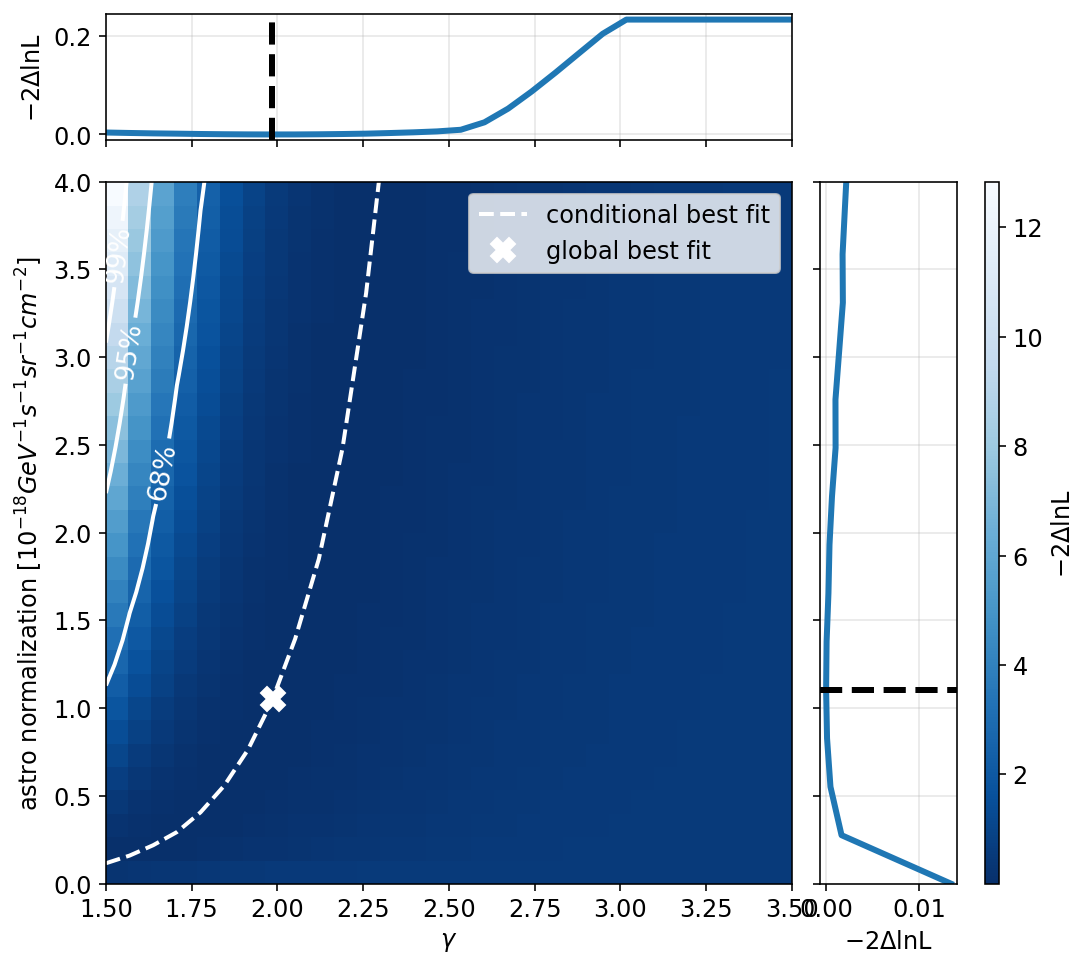

In [723]:
plt.figure(figsize=(8,8))

gspec = gridspec.GridSpec(2, 3,width_ratios=[5,1,0.1], height_ratios=[0.9,5], wspace=0.1, hspace=0.1)

ax1 = plt.subplot(gspec[0])

plt.plot(ggs,ggprof,lw=3)
plt.axvline(ggs[ggprof==np.min(ggprof)],ls='--',lw=3,color='black')
plt.xlim(1.5,3.5)
plt.ylabel(r'$-2\Delta$lnL')
ax1.tick_params(labelbottom=False)    
plt.grid(True,which='both',zorder=0,alpha=0.3)

axbar = plt.subplot(gspec[5])

ax2 = plt.subplot(gspec[3])

h,yy,xx,img=plt.hist2d(gs,ns,weights=t,bins=[len(gammas),len(norms)],range=[[1.5,3.5],[0,4]],cmap='Blues_r')#,norm=matplotlib.colors.LogNorm())
plt.plot(gammas,best_norms,'--',color='white',lw=2,label='conditional best fit')
plt.plot(m.values[1],m.values[0],'X',color='w',ms=12,label='global best fit')
cbar = plt.colorbar(cax=axbar)
cbar.set_label(r'$-2\Delta$lnL') 
CS=plt.contour(h.transpose(),extent=[np.min(gammas),np.max(gammas),np.min(norms),np.max(norms)],levels=CL,colors='white',linewidths=2)
plt.clabel(CS,fmt={CL[0]:'68%',CL[1]:'95%',CL[2]:'99%'},fontsize=13)
plt.legend(loc='upper right',prop={'size': 12})
plt.xlim(1.5,3.5)
plt.ylim(0,4)
plt.xlabel(r'$\gamma$')
plt.ylabel(r'astro normalization [$10^{-18}GeV^{-1}s^{-1}sr^{-1}cm^{-2}$]')
# plt.title('2-parameter model')

ax3 = plt.subplot(gspec[4])

plt.plot(nnprof,nns,lw=3)
plt.axhline(nns[nnprof==np.min(nnprof)],ls='--',lw=3,color='black')
ax3.tick_params(labelleft=False)
plt.ylim(0,4)
plt.xlabel(r'$-2\Delta$lnL')
plt.grid(True,which='both',zorder=0,alpha=0.3)

plt.show()

# 2. H0: no cutoff. H1: cutoff

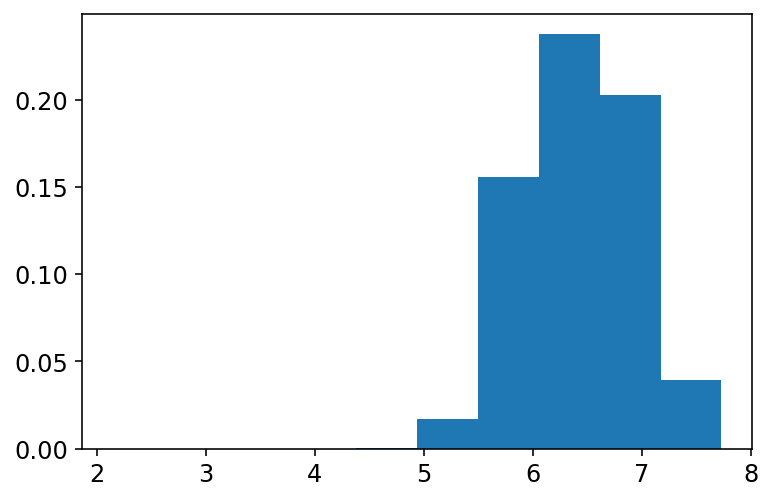

In [730]:
plt.hist(np.log10(prim_e_numu),weights=weight_numu_astro)
plt.show()

In [731]:
def astro_weight_cutoff(norm,gamma,cutoff):
    return norm * 1e-18 * (prim_e_numu/1e5)**(-gamma) * np.exp(-prim_e_numu/cutoff) * OneWeight/(n_file * NEvents) * lifetime * 2


In [732]:
def llh_cutoff(norm,gamma,cutoff): # log likelihood 
    # 'observed data'
    h_corsika_observed, _,_ = np.histogram2d(np.cos(zenith_corsika),np.log10(truncated_muon_e_corsika),weights=weight_corsika,bins=[zenith_bin,energy_bin])
    h_numu_astro_observed, _,_ = np.histogram2d(np.cos(zenith_numu),np.log10(truncated_muon_e_numu),weights=astro_weight_cutoff(norm=6.7/6,gamma=2,cutoff=np.inf),bins=[zenith_bin,energy_bin])
    h_numu_conv_observed, _,_ = np.histogram2d(np.cos(zenith_numu),np.log10(truncated_muon_e_numu),weights=weight_numu_conv,bins=[zenith_bin,energy_bin])
    h_numu_prompt_observed, _,_ = np.histogram2d(np.cos(zenith_numu),np.log10(truncated_muon_e_numu),weights=weight_numu_prompt,bins=[zenith_bin,energy_bin])

    h_observed = h_corsika_observed + h_numu_astro_observed + h_numu_conv_observed + h_numu_prompt_observed
    
    # expected under assumed norm, gamma
    h_corsika, _,_ = np.histogram2d(np.cos(zenith_corsika),np.log10(truncated_muon_e_corsika),weights=weight_corsika,bins=[zenith_bin,energy_bin])
    h_numu_astro, _,_ = np.histogram2d(np.cos(zenith_numu),np.log10(truncated_muon_e_numu),weights=astro_weight_cutoff(norm,gamma,cutoff),bins=[zenith_bin,energy_bin])
    h_numu_conv, _,_ = np.histogram2d(np.cos(zenith_numu),np.log10(truncated_muon_e_numu),weights=weight_numu_conv,bins=[zenith_bin,energy_bin])
    h_numu_prompt, _,_ = np.histogram2d(np.cos(zenith_numu),np.log10(truncated_muon_e_numu),weights=weight_numu_prompt,bins=[zenith_bin,energy_bin])
    
    h_expected = h_corsika + h_numu_astro + h_numu_conv + h_numu_prompt
    
    # log likelihood = sum over bind ( k * log(lam) - lam + logGamma(k+1) )
    llh = h_observed * np.log(h_expected) - h_expected - ci.special.loggamma(h_observed+1)
    llh[(h_observed==0)&(h_expected==0)] = 0
    
    return np.sum(llh)
def negllh_cutoff(norm,gamma,cutoff):
    return -llh_cutoff(norm,gamma,cutoff)

In [733]:
m = mi.Minuit(negllh_cutoff,norm=1,gamma=2,cutoff=1e7,errordef=mi.Minuit.LIKELIHOOD,
              limit_norm=(0.01,4),limit_gamma=(1.5,3.5),limit_cutoff=(1e5,1e8))

In [734]:
m.migrad()

/Users/yang/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:19: RuntimeWarning: divide by zero encountered in log
/Users/yang/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:19: RuntimeWarning: invalid value encountered in multiply


------------------------------------------------------------------
| FCN = 26.33                   |      Ncalls=97 (97 total)      |
| EDM = 7.96e-05 (Goal: 0.0001) |            up = 0.5            |
------------------------------------------------------------------
|  Valid Min.   | Valid Param.  | Above EDM | Reached call limit |
------------------------------------------------------------------
|     True      |     True      |   False   |       False        |
------------------------------------------------------------------
| Hesse failed  |   Has cov.    | Accurate  | Pos. def. | Forced |
------------------------------------------------------------------
|     False     |     True      |   True    |   True    | False  |
------------------------------------------------------------------
--------------------------------------------------------------------------------------------
|   | Name   |   Value   | Hesse Err | Minos Err- | Minos Err+ | Limit-  | Limit+  | Fixed |
--------------------------------------------------------------------------------------------
| 0 | norm   |    0.6    |    2.2    |            |            |  0.01   |    4    |       |
| 1 | gamma  |    1.8    |    1.1    |            |            |   1.5   |   3.5   |       |
| 2 | cutoff |  0.02e9   |  0.07e9   |            |            | 100000  |  1e+08  |       |
--------------------------------------------------------------------------------------------

In [729]:
llh_best = llh_cutoff(m.values[0],m.values[1],m.values[2])

# 2d scan
gammas = np.linspace(1.5,3.5,30) # gamma
cutoffs = np.logspace(5,8,30) # cutoff
cs = []
gs = []
ls = []
for i in range(0,len(gammas)):
    for j in range(0,len(cutoffs)):
        gs.append(gammas[i])
        cs.append(cutoffs[j])
        m_tmp = mi.Minuit(negllh_cutoff,norm=1,gamma=gammas[i],cutoff=cutoffs[j],
                          errordef=mi.Minuit.LIKELIHOOD,fix_gamma=True,fix_cutoff=True,
                          limit_norm=(0.01,4),limit_gamma=(1.5,3.5),limit_cutoff=(1e5,1e8))
        m_tmp.migrad()
        ls.append(llh_cutoff(m_tmp.values[0],gammas[i],cutoffs[j]))
ls = np.array(ls)
t = -2 * (ls - llh_best) # -2 ln (L/L_best_estimate)


/Users/yang/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:19: RuntimeWarning: divide by zero encountered in log
/Users/yang/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:19: RuntimeWarning: invalid value encountered in multiply


RuntimeError: exception was raised in user function
User function arguments:
      norm = +3.965807
     gamma = +2.327586
    cutoff = +853167.852417


In [ ]:
# plt.figure()
# plt.hist(t,bins=30,log=True,histtype='step')
# CLs = np.quantile(t[np.isnan(t)==False],q=[0.68,0.95,0.99])
# CL = [CLs[0],CLs[1],CLs[2]]
# print('test statistic at each confidence level:',CL)
# plt.axvline(CL[0],label='68%',color='r')
# plt.axvline(CL[1],label='95%',color='g')
# plt.axvline(CL[2],label='99%',color='b')
# plt.legend(loc='lower left')
# plt.xlabel('test statistic')
# plt.show()

In [ ]:
# 1d scan 
ggs,ggprof,_ = m.mnprofile("gamma",bound=(1.5,3.5),bins=30)
ggprof = -2 * (-ggprof - llh_best)
# clgg = np.quantile(ggprof,q=[0.68])

ccs,ccprof,_ = m.mnprofile("cutoff",bound=(1e5,1e8),bins=30)
ccprof = -2 * (-ccprof - llh_best)
# clcc = np.quantile(ccprof,q=[0.68])

# path of best fits
best_cutoffs = []
for i in range(0,len(gammas)):
    m_tmp = mi.Minuit(negllh_cutoff,norm=1,gamma=gammas[i],cutoff=6,
                      errordef=mi.Minuit.LIKELIHOOD,fix_gamma=True,
                      limit_norm=(0.01,4),limit_gamma=(1.5,3.5),limit_cutoff=(4,8))    
    m_tmp.migrad()
    best_cutoffs.append(m_tmp.values[2])
    
CL = [2.3,6,9.21] # chi2 distribution of 2 dof, Confidence Intervals

In [ ]:
plt.figure(figsize=(8,8))

gspec = gridspec.GridSpec(2, 3,width_ratios=[5,1,0.1], height_ratios=[0.9,5], wspace=0.1, hspace=0.1)

ax1 = plt.subplot(gspec[0])

plt.plot(ggs,ggprof,lw=3)
plt.axvline(ggs[ggprof==np.min(ggprof)],ls='--',lw=3,color='black')
plt.xlim(1.5,3.5)
plt.ylabel(r'$-2\Delta$lnL')
ax1.tick_params(labelbottom=False)    
plt.grid(True,which='both',zorder=0,alpha=0.3)

axbar = plt.subplot(gspec[5])

ax2 = plt.subplot(gspec[3])

h,yy,xx,img=plt.hist2d(gs,np.log10(cs),weights=t,bins=[len(gammas),len(cutoffs)],range=[[1.5,3.5],[5,8]],cmap='Blues_r')#,norm=matplotlib.colors.LogNorm())
plt.plot(gammas,best_cutoffs,'--',color='white',lw=2,label='conditional best fit')
plt.plot(m.values[1],m.values[2],'X',color='w',ms=12,label='global best fit')
cbar = plt.colorbar(cax=axbar)
cbar.set_label(r'$-2\Delta$lnL') 
CS=plt.contour(h.transpose(),extent=[np.min(gammas),np.max(gammas),np.min(np.log10(cutoffs)),np.max(np.log10(cutoffs))],levels=CL,colors='white',linewidths=2)
plt.clabel(CS,fmt={CL[0]:'68%',CL[1]:'95%',CL[2]:'99%'},fontsize=13)
plt.legend(loc='upper right',prop={'size': 12})
plt.xlim(1.5,3.5)
plt.ylim(5,8)
plt.xlabel(r'$\gamma$')
plt.ylabel('astro cutoff energy [GeV]')
# plt.title('2-parameter model')

ax3 = plt.subplot(gspec[4])

plt.plot(ccprof,np.log10(ccs),lw=3)
plt.axhline(np.log10(ccs[ccprof==np.min(ccprof)]),ls='--',lw=3,color='black')
ax3.tick_params(labelleft=False)
plt.ylim(5,8)
plt.xlabel(r'$-2\Delta$lnL')
plt.grid(True,which='both',zorder=0,alpha=0.3)

plt.show()

# A. HESE only:

In [13]:
neutrino_energy,eff_area_hese_numu = np.loadtxt('/Users/yang/Desktop/TP/eff_area_hese_numu.txt',unpack=True)
_,eff_area_hese_numubar = np.loadtxt('/Users/yang/Desktop/TP/eff_area_hese_numubar.txt',unpack=True)
_,eff_area_hese_nue = np.loadtxt('/Users/yang/Desktop/TP/eff_area_hese_nue.txt',unpack=True)
_,eff_area_hese_nuebar = np.loadtxt('/Users/yang/Desktop/TP/eff_area_hese_nuebar.txt',unpack=True)
_,eff_area_hese_nutau = np.loadtxt('/Users/yang/Desktop/TP/eff_area_hese_nutau.txt',unpack=True)
_,eff_area_hese_nutaubar = np.loadtxt('/Users/yang/Desktop/TP/eff_area_hese_nutaubar.txt',unpack=True)

/Users/yang/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:2: RuntimeWarning: divide by zero encountered in log10
  


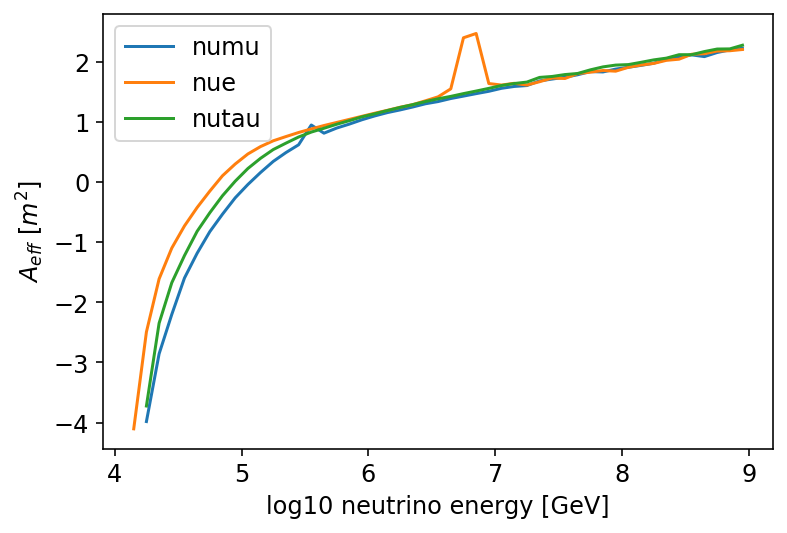

In [792]:
plt.figure(figsize=(6,4))
plt.plot(np.log10(neutrino_energy),np.log10(eff_area_hese_numu),label='numu')
# plt.plot(np.log10(neutrino_energy),np.log10(eff_area_hese_numubar),label='numubar')
plt.plot(np.log10(neutrino_energy),np.log10(eff_area_hese_nue),label='nue')
# plt.plot(np.log10(neutrino_energy),np.log10(eff_area_hese_nuebar),label='nuebar')
plt.plot(np.log10(neutrino_energy),np.log10(eff_area_hese_nutau),label='nutau')
# plt.plot(np.log10(neutrino_energy),np.log10(eff_area_hese_nutaubar),label='nutaubar')
plt.xlabel('log10 neutrino energy [GeV]')
plt.ylabel(r'$A_{eff}$ [$m^2$]')
plt.legend()
plt.show()

In [793]:
Livetime = 86400*365*5

enBin       = np.logspace(4,9,26)   # [10TeV, 100PeV]

lBinEdge    = enBin[:-1]                # left bin edge
rBinEdge    = enBin[1:]                 # right bin edge
enBinCent   = np.sqrt( enBin[:-1] * enBin[1:] )  # geometric mean, log(bincent) = 1/2(log(left)+log(right))
nPts        = enBinCent.size

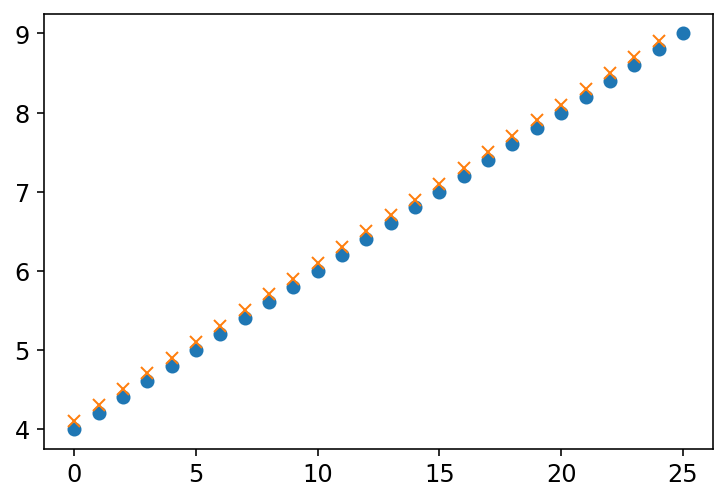

In [842]:
plt.plot(np.log10(enBin),'o')
plt.plot(np.log10(enBinCent),'x')

In [794]:
# return flux per energy bin, [1/GeV/s/sr/cm^2] 
# Note the unit of flux itself is [1/GeV/s/sr/cm^2], but it depends on energy: phi = phi(E).
# need to sum over phi: integral(phi(E)dE) in each bins to discretize, then return flux in each energy bin. 

def astroFlux( fluxNormMult, specIdx, energyCut): 

    avgAstroFlux = np.zeros(nPts, dtype = np.float64 )

    for i, (loLim, upLim) in enumerate(zip(lBinEdge, rBinEdge)):
        avgAstroFlux[i] = fluxNormMult * 1e-18 * quad( lambda E: \
                             (E/1e5)**(-specIdx) * np.exp(-E/energyCut),
                             loLim, upLim )[0]
    return avgAstroFlux

In [880]:
def getAeffInterp(energy, eff_area_per_type): # get eff area values [cm^2] at certain energy values 

    # Values extrapolated out of the original range are set to zero.
    InterpAeff = interp1d(energy, eff_area_per_type, bounds_error = False, fill_value = 0. )

    # Aeff is in m^2, while fluxes are in cm^2, so multiply by 1.e4 to
    # covert.  NOTE:  THE EFFECTIVE AREAS ARE NOT ADDED, SO _NO_ DIVISION BY
    # 2 FOR PER TYPE
    ##### !!!!! correction, they were added so /2 is needed!
    effArea = 1e4 * InterpAeff(enBinCent) # get vals at enBinCent

    return effArea

In [796]:
# get eff area values at enBinCent locations

# HESE
AeffNuMuHESE    = getAeffInterp(neutrino_energy,eff_area_hese_numu)
AeffNuMuBarHESE    = getAeffInterp(neutrino_energy,eff_area_hese_numubar)
AeffNuEHESE    = getAeffInterp(neutrino_energy,eff_area_hese_nue)
AeffNuEBarHESE    = getAeffInterp(neutrino_energy,eff_area_hese_nuebar)
AeffNuTauHESE    = getAeffInterp(neutrino_energy,eff_area_hese_nutau)
AeffNuTauBarHESE    = getAeffInterp(neutrino_energy,eff_area_hese_nutaubar)

# myown
AeffNuMuMY   = getAeffInterp(neutrino_energy_my,effective_area_numu_my) # should be both nu + nubar
# AeffNuMuBarMY   = getAeffInterp(neutrino_energy_my,effective_area_numubar_my)

/Users/yang/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1: RuntimeWarning: divide by zero encountered in log10
  """Entry point for launching an IPython kernel.


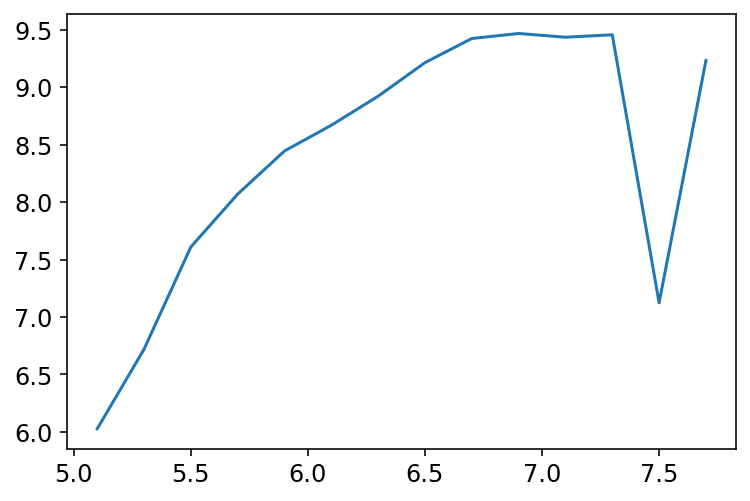

In [797]:
plt.plot(np.log10(enBinCent),np.log10(AeffNuMuMY))

In [798]:
# dN/dE, number of events in certain energy bins. 
# dN/dE = flux(dPhi/dE for each energy bin) * solid_angle * Aeff(at each energy) * time
def dNobs( dNdEAstro, Aeff, Livetime ): # should have conv and prompt, but ignore for now
    dNobsAstro   = 4 * np.pi * Aeff * dNdEAstro * Livetime
    dNobs = dNobsAstro.copy() # + conv and prompt
    return dNobs

In [799]:
def dNObsBreakDown( dNdEAstro, Aeff, Livetime ): # return total and each contribution
    dNobsAstro   = 4 * np.pi * Aeff * dNdEAstro * Livetime
    dNobs =  dNobsAstro.copy()
    return dNobs, dNobsAstro

In [800]:
# 1. HESE
GenAstroFlux = astroFlux(fluxNormMult = 2.3/2,specIdx = 2.5,energyCut = np.inf) # 'observed' HESE flux

dNObsNuMuHESE, dNObsAstroNuMuHESE = dNObsBreakDown(GenAstroFlux, AeffNuMuHESE, Livetime)
dNObsNuMuBarHESE, dNObsAstroNuMuBarHESE = dNObsBreakDown(GenAstroFlux, AeffNuMuBarHESE, Livetime)
dNObsNuEHESE, dNObsAstroNuEHESE = dNObsBreakDown(GenAstroFlux, AeffNuEHESE, Livetime)
dNObsNuEBarHESE, dNObsAstroNuEBarHESE = dNObsBreakDown(GenAstroFlux, AeffNuEBarHESE, Livetime)
dNObsNuTauHESE, dNObsAstroNuTauHESE = dNObsBreakDown(GenAstroFlux, AeffNuTauHESE, Livetime)
dNObsNuTauBarHESE, dNObsAstroNuTauBarHESE = dNObsBreakDown(GenAstroFlux, AeffNuTauBarHESE, Livetime)

# total observed HESE
dNObsTotHESE = dNObsNuMuHESE +\
                dNObsNuMuBarHESE +\
                dNObsNuEHESE +\
                dNObsNuEBarHESE +\
                dNObsNuTauHESE +\
                dNObsNuTauBarHESE

# sub: total observed astro
dNObsAstroHESE = dNObsAstroNuMuHESE +\
                dNObsAstroNuMuBarHESE +\
                dNObsAstroNuEHESE +\
                dNObsAstroNuEBarHESE +\
                dNObsAstroNuTauHESE +\
                dNObsAstroNuTauBarHESE

# 2. myown
GenAstroFlux_MY = astroFlux(fluxNormMult = 6.7/6,specIdx = 2,energyCut = np.inf) # 'observed' diffuse flux
# sub: 
dNObsNuMuMY, dNObsAstroNuMuMY = dNObsBreakDown(GenAstroFlux_MY, AeffNuMuMY, Livetime) # UNIT???
dNObsNuMuBarMY, dNObsAstroNuMuBarMY = dNObsBreakDown(GenAstroFlux_MY, AeffNuMuMY, Livetime) # UNIT???

# UNIT???
dNObsNuMuMY /= 1e4
dNObsAstroNuMuMY /= 1e4

# 3. total 
dNObsTot = dNObsTotHESE + dNObsNuMuMY
print(np.sum(dNObsNuMuMY))
# sub: 
# dNObsAstroTot = ... 

3.4432658304275687


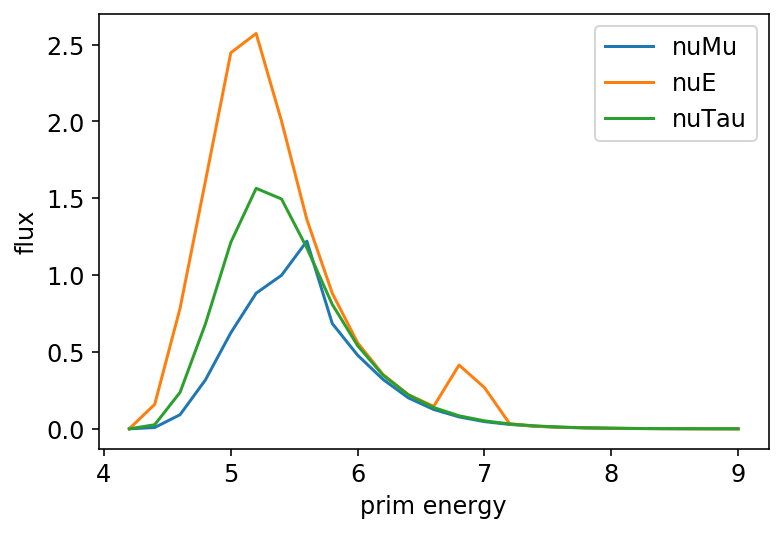

In [801]:
plt.plot(np.log10(enBin[1:]),dNObsNuMuHESE,label='nuMu')
plt.plot(np.log10(enBin[1:]),dNObsNuEHESE,label='nuE')
plt.plot(np.log10(enBin[1:]),dNObsNuTauHESE,label='nuTau')
plt.legend()
plt.xlabel('prim energy')
plt.ylabel('flux')
plt.show()

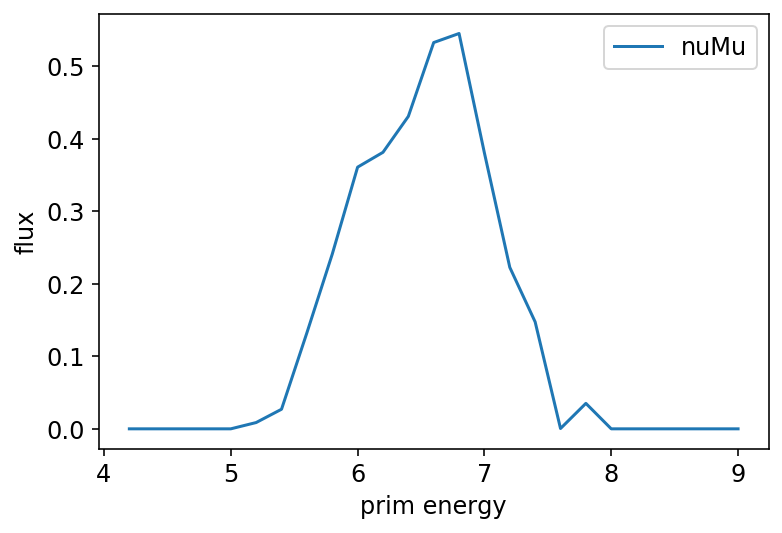

In [802]:
plt.plot(np.log10(enBin[1:]),dNObsNuMuMY,label='nuMu')
plt.legend()
plt.xlabel('prim energy')
plt.ylabel('flux')
plt.show()

In [803]:
np.sum(dNObsNuMuMY)

3.4432658304275687

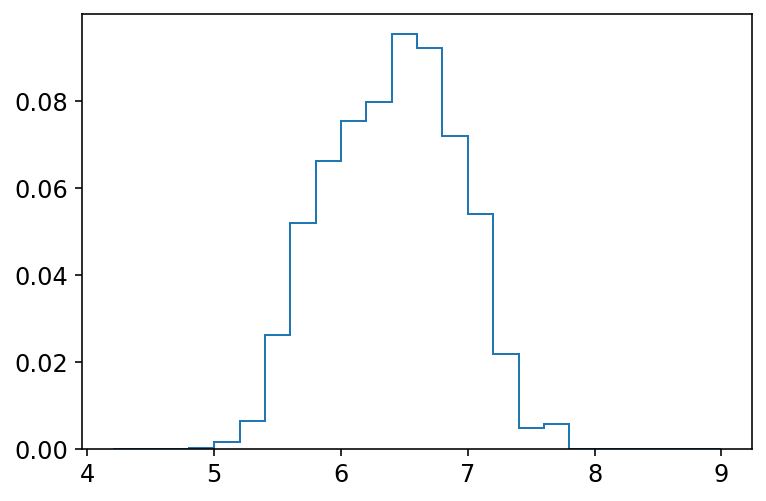

In [804]:
plt.hist(np.log10(prim_e_numu),weights=weight_numu_astro,bins=np.log10(enBin[1:]),histtype='step')
plt.show()

In [805]:
np.sum(weight_numu_astro)

0.6520567260161894

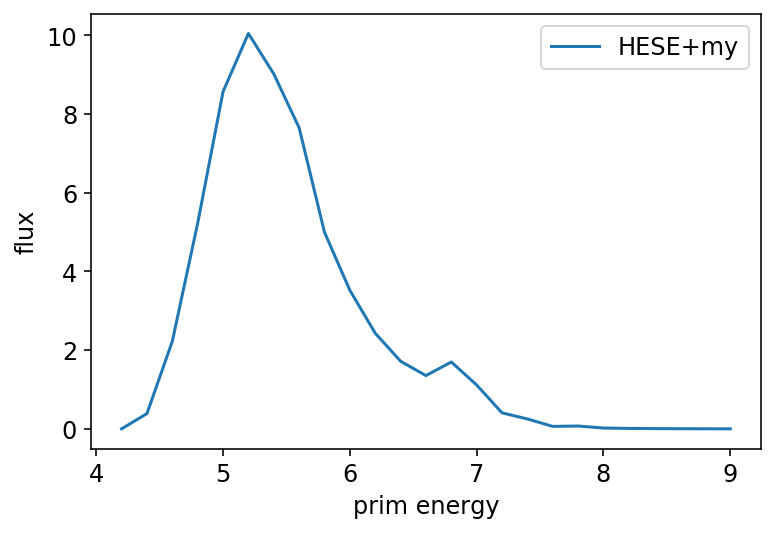

In [806]:
plt.plot(np.log10(enBin[1:]),dNObsTot,label='HESE+my')
plt.legend()
plt.xlabel('prim energy')
plt.ylabel('flux')
plt.show()

In [807]:
print("****** HESE Sample ********* " )
print("****** dNObsTotHESE ******** = " + str(np.sum(dNObsTotHESE)))

print("****** dNObsNuEHESE ******** = " + str(np.sum(dNObsNuEHESE)))
print("****** dNObsNuEBarHESE ******** = " + str(np.sum(dNObsNuEBarHESE)))

print(" E % = " + str (  (np.sum(dNObsNuEHESE) +  np.sum(dNObsNuEBarHESE))*100/(np.sum(dNObsTotHESE)) ) )


print("****** dNObsAstroHESE ********* = " + str(np.sum(dNObsAstroHESE)))
print("****** dNObsAstroHESE E + EBar ********* = " + str(np.sum(dNObsNuEHESE) + np.sum(dNObsNuEBarHESE)))


****** HESE Sample ********* 
****** dNObsTotHESE ******** = 57.377593672199765
****** dNObsNuEHESE ******** = 13.861752853825383
****** dNObsNuEBarHESE ******** = 13.861752853825383
 E % = 48.31765142685512
****** dNObsAstroHESE ********* = 57.377593672199765
****** dNObsAstroHESE E + EBar ********* = 27.723505707650766


In [808]:
def llh(norm, gamma, cutoff): # data: no cutoff
    astroFluxArrPredicted = astroFlux(norm,gamma,cutoff) # varying flux 
    
    dNPredNuMu = dNobs(astroFluxArrPredicted, AeffNuMuHESE, Livetime)
    dNPredNuMuBar = dNobs(astroFluxArrPredicted, AeffNuMuBarHESE, Livetime)
    dNPredNuE = dNobs(astroFluxArrPredicted, AeffNuEHESE, Livetime)
    dNPredNuEBar = dNobs(astroFluxArrPredicted, AeffNuEBarHESE, Livetime)
    dNPredNuTau = dNobs(astroFluxArrPredicted, AeffNuTauHESE, Livetime)
    dNPredNuTauBar = dNobs(astroFluxArrPredicted, AeffNuTauBarHESE, Livetime)
    
    dNPredTotHESE = dNPredNuMu +\
                    dNPredNuMuBar +\
                    dNPredNuE +\
                    dNPredNuEBar +\
                    dNPredNuTau +\
                    dNPredNuTauBar
    
    # calculating log likelihood using Sterling approx
    
    llh = np.where(dNObsTotHESE > 0, 
                   dNObsTotHESE*np.log(dNPredTotHESE)-dNPredTotHESE-(dNObsTotHESE*np.log(dNObsTotHESE)-dNObsTotHESE),
                   -dNPredTotHESE)
    llh = np.sum(llh)
    return llh

def negllh(norm, gamma, cutoff):
    return -llh(norm, gamma, cutoff)

## 1. HESE only; norm vs. gamma; data: no cutoff, model: no cutoff

In [809]:
m = mi.Minuit(negllh,
              norm=1.,gamma=2.5,cutoff=np.inf,
              limit_norm=(0.01,4),limit_gamma=(1.5,3.5),limit_cutoff=None,
              fix_norm=False,fix_gamma=False,fix_cutoff=True,
              errordef=mi.Minuit.LIKELIHOOD,pedantic=True,
             )

In [810]:
m.migrad()

------------------------------------------------------------------
| FCN = 4.048e-08               |      Ncalls=35 (35 total)      |
| EDM = 4.05e-08 (Goal: 0.0001) |            up = 0.5            |
------------------------------------------------------------------
|  Valid Min.   | Valid Param.  | Above EDM | Reached call limit |
------------------------------------------------------------------
|     True      |     True      |   False   |       False        |
------------------------------------------------------------------
| Hesse failed  |   Has cov.    | Accurate  | Pos. def. | Forced |
------------------------------------------------------------------
|     False     |     True      |   True    |   True    | False  |
------------------------------------------------------------------
--------------------------------------------------------------------------------------------
|   | Name   |   Value   | Hesse Err | Minos Err- | Minos Err+ | Limit-  | Limit+  | Fixed |
--------------------------------------------------------------------------------------------
| 0 | norm   |   1.15    |   0.18    |            |            |  0.01   |    4    |       |
| 1 | gamma  |    2.5    |    0.1    |            |            |   1.5   |   3.5   |       |
| 2 | cutoff |    inf    |    inf    |            |            |         |         |  yes  |
--------------------------------------------------------------------------------------------

In [811]:
llh_best = llh(m.values[0],m.values[1],m.values[2])

In [812]:
# 2d scan
norms = np.linspace(0.01,4,30) # norm
gammas = np.linspace(1.5,3.5,30) # gamma
ns = []
gs = []
ls = []
for i in range(0,len(norms)):
    for j in range(0,len(gammas)):
        ns.append(norms[i])
        gs.append(gammas[j])
        m_tmp = mi.Minuit(negllh,
                          norm=norms[i],gamma=gammas[j],cutoff=np.inf,
                          limit_norm=None,limit_gamma=None,limit_cutoff=None,
                          fix_norm=True,fix_gamma=True,fix_cutoff=True,
                          errordef=mi.Minuit.LIKELIHOOD,pedantic=True,
                         )
        m_tmp.migrad()
        ls.append(llh(norms[i],gammas[j],np.inf))
ls = np.array(ls)
t = -2 * (ls - llh_best) # -2 ln (L/L_best_estimate)

# 1d scan 
nns,nnprof,_ = m.mnprofile("norm",bound=(0.01,4),bins=30)
nnprof = -2 * (-nnprof - llh_best)

ggs,ggprof,_ = m.mnprofile("gamma",bound=(1.5,3.5),bins=30)
ggprof = -2 * (-ggprof - llh_best)

In [813]:
CL = [2.3, 6.0, 9.21] # chi2 distribution of 2 dof, Confidence Intervals

# path of best fits
best_norms = []
for i in range(0,len(gammas)):
    m_tmp = mi.Minuit(negllh,
                      norm=1,gamma=gammas[i],cutoff=np.inf,
                      limit_norm=(0.01,4),limit_gamma=(1.5,3.5),limit_cutoff=None,
                      fix_norm=False,fix_gamma=True,fix_cutoff=True,
                      errordef=mi.Minuit.LIKELIHOOD,pedantic=True,
                     )
    m_tmp.migrad()
    best_norms.append(m_tmp.values[0])

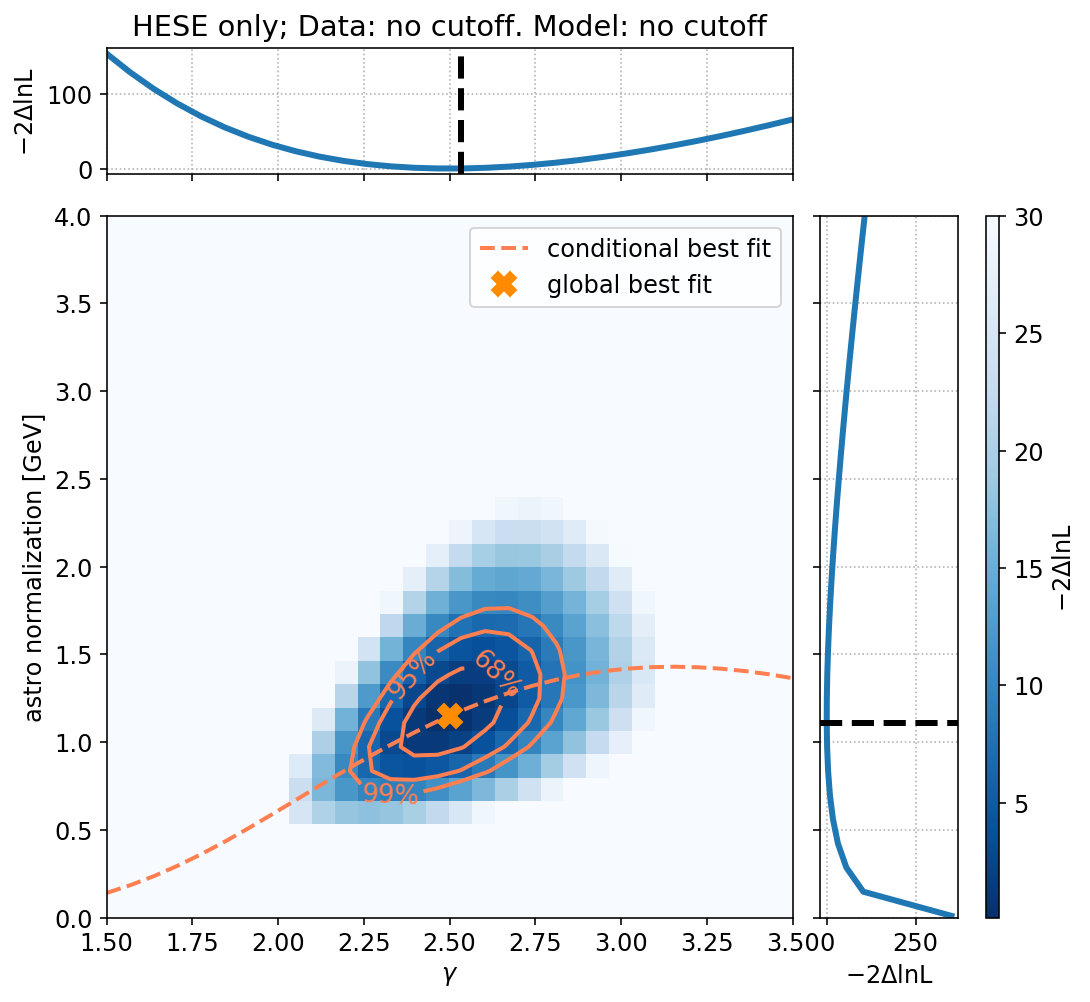

In [814]:
plt.figure(figsize=(8,8))

gspec = gridspec.GridSpec(2, 3,width_ratios=[5,1,0.1], height_ratios=[0.9,5], wspace=0.1, hspace=0.1)

ax1 = plt.subplot(gspec[0])

plt.plot(ggs,ggprof,lw=3)
plt.axvline(ggs[ggprof==np.min(ggprof)],ls='--',lw=3,color='black')
plt.xlim(1.5,3.5)
plt.ylabel(r'$-2\Delta$lnL')
plt.title('HESE only; Data: no cutoff. Model: no cutoff')
ax1.tick_params(labelbottom=False)    
plt.grid(True,which='both',zorder=0,linestyle=':')
axbar = plt.subplot(gspec[5])

ax2 = plt.subplot(gspec[3])

h,yy,xx,img=plt.hist2d(gs,ns,weights=t.clip(-np.inf,30),bins=[len(gammas),len(norms)],range=[[1.5,3.5],[0,4]],cmap='Blues_r')#,norm=LogNorm())
plt.plot(gammas,best_norms,'--',color='coral',lw=2,label='conditional best fit')
plt.plot(m.values[1],m.values[0],'X',color='darkorange',ms=12,label='global best fit')
cbar = plt.colorbar(cax=axbar)
cbar.set_label(r'$-2\Delta$lnL') 
CS=plt.contour(h.transpose(),extent=[np.min(gammas),np.max(gammas),np.min(norms),np.max(norms)],levels=CL,colors='coral',linewidths=2)
plt.clabel(CS,fmt={CL[0]:'68%',CL[1]:'95%',CL[2]:'99%'},fontsize=13)
plt.legend(loc='upper right',prop={'size': 12})
plt.xlim(1.5,3.5)
plt.ylim(0,4)
plt.xlabel(r'$\gamma$')
plt.ylabel('astro normalization [GeV]')

ax3 = plt.subplot(gspec[4])

plt.plot(nnprof,nns,lw=3)
plt.axhline(nns[nnprof==np.min(nnprof)],ls='--',lw=3,color='black')
ax3.tick_params(labelleft=False)
plt.ylim(0,4)
plt.xlabel(r'$-2\Delta$lnL')
plt.grid(True,which='both',zorder=0,linestyle=':')

plt.show()

## 2. HESE only; cutoff vs. gamma; data: no cutoff, model: cutoff

In [815]:
m = mi.Minuit(negllh,
              norm=1.,gamma=2.5,cutoff=1e7,
              limit_norm=(0.01,4),limit_gamma=(1.5,3.5),limit_cutoff=(1e5,1e8),
              fix_norm=False,fix_gamma=False,fix_cutoff=False,
              error_norm=0.125,error_gamma=0.25,error_cutoff=1e5,
              errordef=mi.Minuit.LIKELIHOOD,pedantic=True,
             )

In [816]:
m.migrad()

------------------------------------------------------------------
| FCN = 0.05408                 |     Ncalls=119 (119 total)     |
| EDM = 5.01e-07 (Goal: 0.0001) |            up = 0.5            |
------------------------------------------------------------------
|  Valid Min.   | Valid Param.  | Above EDM | Reached call limit |
------------------------------------------------------------------
|     True      |     True      |   False   |       False        |
------------------------------------------------------------------
| Hesse failed  |   Has cov.    | Accurate  | Pos. def. | Forced |
------------------------------------------------------------------
|     False     |     True      |   True    |   True    | False  |
------------------------------------------------------------------
--------------------------------------------------------------------------------------------
|   | Name   |   Value   | Hesse Err | Minos Err- | Minos Err+ | Limit-  | Limit+  | Fixed |
--------------------------------------------------------------------------------------------
| 0 | norm   |   1.15    |   0.18    |            |            |  0.01   |    4    |       |
| 1 | gamma  |   2.49    |   0.10    |            |            |   1.5   |   3.5   |       |
| 2 | cutoff |  0.10e9   |  0.07e9   |            |            | 100000  |  1e+08  |       |
--------------------------------------------------------------------------------------------

In [817]:
llh_best = llh(m.values[0],m.values[1],m.values[2])

In [818]:
# 2d scan
gammas = np.linspace(1.5,3.5,30) # gamma
cutoffs = np.logspace(5,8,30) # cutoff
cs = []
gs = []
ls = []
for i in range(0,len(gammas)):
    for j in range(0,len(cutoffs)):
        gs.append(gammas[i])
        cs.append(cutoffs[j])
        m_tmp = mi.Minuit(negllh,
                          norm=1.,gamma=gammas[i],cutoff=cutoffs[j],
                          limit_norm=(0.01,4),limit_gamma=(1.5,3.5),limit_cutoff=(1e5,1e8),
                          fix_norm=False,fix_gamma=True,fix_cutoff=True,
                          errordef=mi.Minuit.LIKELIHOOD,pedantic=True,
                         )
        m_tmp.migrad()
        ls.append(llh(m_tmp.values[0],gammas[i],cutoffs[j]))
ls = np.array(ls)
t = -2 * (ls - llh_best) # -2 ln (L/L_best_estimate)

/Users/yang/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:21: RuntimeWarning: divide by zero encountered in log


In [819]:
# 1d scan 
ggs,ggprof,_ = m.mnprofile("gamma",bound=(1.5,3.5),bins=30)
ggprof = -2 * (-ggprof - llh_best)

ccs,ccprof,_ = m.mnprofile("cutoff",bound=(1e5,1e8),bins=30)
ccprof = -2 * (-ccprof - llh_best)

# path of best fits
best_cutoffs = []
for i in range(0,len(gammas)):
    m_tmp = mi.Minuit(negllh,
                      norm=1,gamma=gammas[i],cutoff=1e7,
                      limit_norm=(0.01,4),limit_gamma=(1.5,3.5),limit_cutoff=(1e5,1e8),
                      fix_norm=False,fix_gamma=True,fix_cutoff=False,
                      errordef=mi.Minuit.LIKELIHOOD,pedantic=True,
                     )
    m_tmp.migrad()
    best_cutoffs.append(m_tmp.values[2])

CL = [2.3, 6.0, 9.21] # chi2 distribution of 2 dof, Confidence Intervals

/Users/yang/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:21: RuntimeWarning: divide by zero encountered in log
/Users/yang/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:10: IntegrationWarning: The occurrence of roundoff error is detected, which prevents 
  the requested tolerance from being achieved.  The error may be 
  underestimated.
  # Remove the CWD from sys.path while we load stuff.


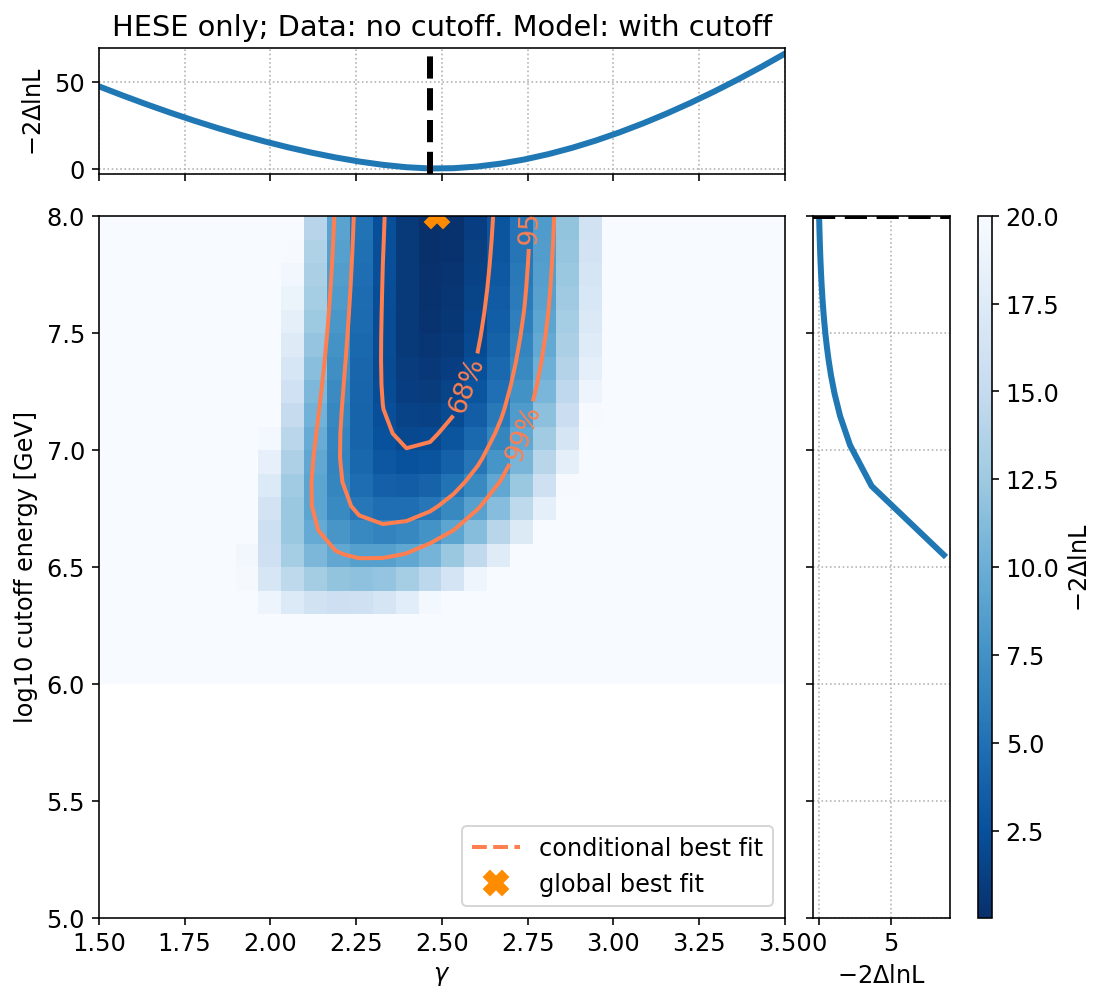

In [820]:
plt.figure(figsize=(8,8))

gspec = gridspec.GridSpec(2, 3,width_ratios=[5,1,0.1], height_ratios=[0.9,5], wspace=0.1, hspace=0.1)

ax1 = plt.subplot(gspec[0])

plt.plot(ggs,ggprof,lw=3)
plt.axvline(ggs[ggprof==np.min(ggprof)],ls='--',lw=3,color='black')
plt.xlim(1.5,3.5)
plt.ylabel(r'$-2\Delta$lnL')
plt.title('HESE only; Data: no cutoff. Model: with cutoff')
ax1.tick_params(labelbottom=False)    
plt.grid(True,which='both',zorder=0,linestyle=':')

axbar = plt.subplot(gspec[5])

ax2 = plt.subplot(gspec[3])

h,yy,xx,img=plt.hist2d(gs,np.log10(cs),weights=t.clip(-np.inf,20),bins=[len(gammas),len(cutoffs)],range=[[1.5,3.5],[5,8]],cmap='Blues_r')#,norm=LogNorm())
plt.plot(gammas,best_cutoffs,'--',color='coral',lw=2,label='conditional best fit')
plt.plot(m.values[1],np.log10(m.values[2]),'X',color='darkorange',ms=12,label='global best fit')
cbar = plt.colorbar(cax=axbar)
cbar.set_label(r'$-2\Delta$lnL') 
CS=plt.contour(h.transpose(),extent=[np.min(gammas),np.max(gammas),np.min(np.log10(cutoffs)),np.max(np.log10(cutoffs))],levels=CL,colors='coral',linewidths=2)
plt.clabel(CS,fmt={CL[0]:'68%',CL[1]:'95%',CL[2]:'99%'},fontsize=13)
plt.legend(loc='lower right',prop={'size': 12})
plt.xlim(1.5,3.5)
plt.ylim(5,8)
plt.xlabel(r'$\gamma$')
plt.ylabel('log10 cutoff energy [GeV]')

ax3 = plt.subplot(gspec[4])

plt.plot(ccprof,np.log10(ccs),lw=3)
plt.axhline(np.log10(ccs[ccprof==np.min(ccprof)]),ls='--',lw=3,color='black')
ax3.tick_params(labelleft=False)
plt.ylim(5,8)
plt.xlabel(r'$-2\Delta$lnL')
plt.grid(True,which='both',zorder=0,linestyle=':')

plt.show()

## 3. HESE + myown; norm vs. gamma; data: no cutoff, model: no cutoff

In [821]:
def llh(norm, gamma, cutoff): # data: no cutoff
    astroFluxArrPredicted = astroFlux(norm,gamma,cutoff) # varying flux 
    
    dNPredNuMuHESE = dNobs(astroFluxArrPredicted, AeffNuMuHESE, Livetime)
    dNPredNuMuBarHESE = dNobs(astroFluxArrPredicted, AeffNuMuBarHESE, Livetime)
    dNPredNuEHESE = dNobs(astroFluxArrPredicted, AeffNuEHESE, Livetime)
    dNPredNuEBarHESE = dNobs(astroFluxArrPredicted, AeffNuEBarHESE, Livetime)
    dNPredNuTauHESE = dNobs(astroFluxArrPredicted, AeffNuTauHESE, Livetime)
    dNPredNuTauBarHESE = dNobs(astroFluxArrPredicted, AeffNuTauBarHESE, Livetime)
    
    dNPredTotHESE = dNPredNuMuHESE +\
                    dNPredNuMuBarHESE +\
                    dNPredNuEHESE +\
                    dNPredNuEBarHESE +\
                    dNPredNuTauHESE +\
                    dNPredNuTauBarHESE
    
    dNPredNuMuMy = dNobs(astroFluxArrPredicted, AeffNuMuMY, Livetime)/1e4
    
    dNPredTot = dNPredTotHESE + dNPredNuMuMy
#     print(dNPredTot,dNPredTotHESE,dNPredNuMuMy)
    # calculating log likelihood using Sterling approx
    
    llh = np.where(dNObsTot > 0, 
                   dNObsTot*np.log(dNPredTot)-dNPredTot-(dNObsTot*np.log(dNObsTot)-dNObsTot),
                   -dNPredTot)
    llh = np.sum(llh)
    return llh

def negllh(norm, gamma, cutoff):
    return -llh(norm, gamma, cutoff)

In [822]:
llh(1,2,1e9)

-20.24407919577833

In [823]:
m = mi.Minuit(negllh,
              norm=1.,gamma=2.5,cutoff=np.inf,
              limit_norm=(0.01,4),limit_gamma=(1.5,3.5),limit_cutoff=None,
              fix_norm=False,fix_gamma=False,fix_cutoff=True,
              errordef=mi.Minuit.LIKELIHOOD,pedantic=True,
             )

In [824]:
m.migrad()

------------------------------------------------------------------
| FCN = 0.1466                  |      Ncalls=29 (29 total)      |
| EDM = 1.06e-06 (Goal: 0.0001) |            up = 0.5            |
------------------------------------------------------------------
|  Valid Min.   | Valid Param.  | Above EDM | Reached call limit |
------------------------------------------------------------------
|     True      |     True      |   False   |       False        |
------------------------------------------------------------------
| Hesse failed  |   Has cov.    | Accurate  | Pos. def. | Forced |
------------------------------------------------------------------
|     False     |     True      |   True    |   True    | False  |
------------------------------------------------------------------
--------------------------------------------------------------------------------------------
|   | Name   |   Value   | Hesse Err | Minos Err- | Minos Err+ | Limit-  | Limit+  | Fixed |
--------------------------------------------------------------------------------------------
| 0 | norm   |   1.14    |   0.17    |            |            |  0.01   |    4    |       |
| 1 | gamma  |   2.43    |   0.10    |            |            |   1.5   |   3.5   |       |
| 2 | cutoff |    inf    |    inf    |            |            |         |         |  yes  |
--------------------------------------------------------------------------------------------

In [825]:
llh_best = llh(m.values[0],m.values[1],m.values[2])

In [826]:
# 2d scan
norms = np.linspace(0.01,4,30) # norm
gammas = np.linspace(1.5,3.5,30) # gamma
ns = []
gs = []
ls = []
for i in range(0,len(norms)):
    for j in range(0,len(gammas)):
        ns.append(norms[i])
        gs.append(gammas[j])
        m_tmp = mi.Minuit(negllh,
                          norm=norms[i],gamma=gammas[j],cutoff=np.inf,
                          limit_norm=None,limit_gamma=None,limit_cutoff=None,
                          fix_norm=True,fix_gamma=True,fix_cutoff=True,
                          errordef=mi.Minuit.LIKELIHOOD,pedantic=True,
                         )
        m_tmp.migrad()
        ls.append(llh(norms[i],gammas[j],np.inf))
ls = np.array(ls)
t = -2 * (ls - llh_best) # -2 ln (L/L_best_estimate)

# 1d scan 
nns,nnprof,_ = m.mnprofile("norm",bound=(0.01,4),bins=30)
nnprof = -2 * (-nnprof - llh_best)

ggs,ggprof,_ = m.mnprofile("gamma",bound=(1.5,3.5),bins=30)
ggprof = -2 * (-ggprof - llh_best)

In [827]:
CL = [2.3, 6.0, 9.21] # chi2 distribution of 2 dof, Confidence Intervals

# path of best fits
best_norms = []
for i in range(0,len(gammas)):
    m_tmp = mi.Minuit(negllh,
                      norm=1,gamma=gammas[i],cutoff=np.inf,
                      limit_norm=(0.01,4),limit_gamma=(1.5,3.5),limit_cutoff=None,
                      fix_norm=False,fix_gamma=True,fix_cutoff=True,
                      errordef=mi.Minuit.LIKELIHOOD,pedantic=True,
                     )
    m_tmp.migrad()
    best_norms.append(m_tmp.values[0])

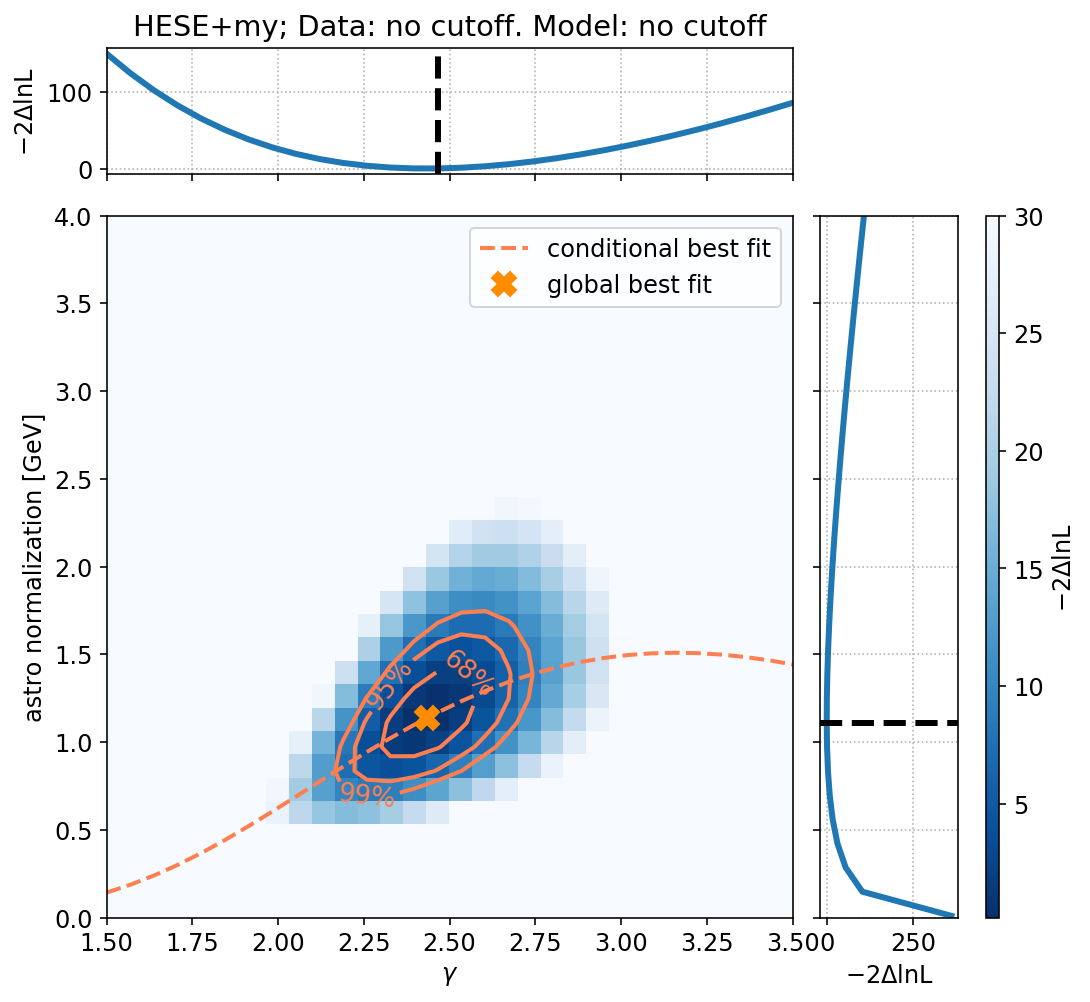

In [828]:
plt.figure(figsize=(8,8))

gspec = gridspec.GridSpec(2, 3,width_ratios=[5,1,0.1], height_ratios=[0.9,5], wspace=0.1, hspace=0.1)

ax1 = plt.subplot(gspec[0])

plt.plot(ggs,ggprof,lw=3)
plt.axvline(ggs[ggprof==np.min(ggprof)],ls='--',lw=3,color='black')
plt.xlim(1.5,3.5)
plt.ylabel(r'$-2\Delta$lnL')
plt.title('HESE+my; Data: no cutoff. Model: no cutoff')
ax1.tick_params(labelbottom=False)    
plt.grid(True,which='both',zorder=0,linestyle=':')
axbar = plt.subplot(gspec[5])

ax2 = plt.subplot(gspec[3])

h,yy,xx,img=plt.hist2d(gs,ns,weights=t.clip(-np.inf,30),bins=[len(gammas),len(norms)],range=[[1.5,3.5],[0,4]],cmap='Blues_r')#,norm=LogNorm())
plt.plot(gammas,best_norms,'--',color='coral',lw=2,label='conditional best fit')
plt.plot(m.values[1],m.values[0],'X',color='darkorange',ms=12,label='global best fit')
cbar = plt.colorbar(cax=axbar)
cbar.set_label(r'$-2\Delta$lnL') 
CS=plt.contour(h.transpose(),extent=[np.min(gammas),np.max(gammas),np.min(norms),np.max(norms)],levels=CL,colors='coral',linewidths=2)
plt.clabel(CS,fmt={CL[0]:'68%',CL[1]:'95%',CL[2]:'99%'},fontsize=13)
plt.legend(loc='upper right',prop={'size': 12})
plt.xlim(1.5,3.5)
plt.ylim(0,4)
plt.xlabel(r'$\gamma$')
plt.ylabel('astro normalization [GeV]')

ax3 = plt.subplot(gspec[4])

plt.plot(nnprof,nns,lw=3)
plt.axhline(nns[nnprof==np.min(nnprof)],ls='--',lw=3,color='black')
ax3.tick_params(labelleft=False)
plt.ylim(0,4)
plt.xlabel(r'$-2\Delta$lnL')
plt.grid(True,which='both',zorder=0,linestyle=':')

plt.show()

## 4. HESE + myown; cutoff vs. gamma; data: no cutoff, model: cutoff

In [829]:
m = mi.Minuit(negllh,
              norm=1.,gamma=2.5,cutoff=1e7,
              limit_norm=(0.01,4),limit_gamma=(1.5,3.5),limit_cutoff=(1e5,1e8),
              fix_norm=False,fix_gamma=False,fix_cutoff=False,
              error_norm=0.125,error_gamma=0.25,error_cutoff=1e5,
              errordef=mi.Minuit.LIKELIHOOD,pedantic=True,
             )

In [830]:
m.migrad()

------------------------------------------------------------------
| FCN = 0.2256                  |     Ncalls=110 (110 total)     |
| EDM = 3.87e-08 (Goal: 0.0001) |            up = 0.5            |
------------------------------------------------------------------
|  Valid Min.   | Valid Param.  | Above EDM | Reached call limit |
------------------------------------------------------------------
|     True      |     True      |   False   |       False        |
------------------------------------------------------------------
| Hesse failed  |   Has cov.    | Accurate  | Pos. def. | Forced |
------------------------------------------------------------------
|     False     |     True      |   True    |   True    | False  |
------------------------------------------------------------------
--------------------------------------------------------------------------------------------
|   | Name   |   Value   | Hesse Err | Minos Err- | Minos Err+ | Limit-  | Limit+  | Fixed |
--------------------------------------------------------------------------------------------
| 0 | norm   |   1.13    |   0.17    |            |            |  0.01   |    4    |       |
| 1 | gamma  |   2.42    |   0.10    |            |            |   1.5   |   3.5   |       |
| 2 | cutoff |  0.10e9   |  0.09e9   |            |            | 100000  |  1e+08  |       |
--------------------------------------------------------------------------------------------

In [831]:
llh_best = llh(m.values[0],m.values[1],m.values[2])

In [832]:
# 2d scan
gammas = np.linspace(1.5,3.5,30) # gamma
cutoffs = np.logspace(5,8,30) # cutoff
cs = []
gs = []
ls = []
for i in range(0,len(gammas)):
    for j in range(0,len(cutoffs)):
        gs.append(gammas[i])
        cs.append(cutoffs[j])
        m_tmp = mi.Minuit(negllh,
                          norm=1.,gamma=gammas[i],cutoff=cutoffs[j],
                          limit_norm=(0.01,4),limit_gamma=(1.5,3.5),limit_cutoff=(1e5,1e8),
                          fix_norm=False,fix_gamma=True,fix_cutoff=True,
                          errordef=mi.Minuit.LIKELIHOOD,pedantic=True,
                         )
        m_tmp.migrad()
        ls.append(llh(m_tmp.values[0],gammas[i],cutoffs[j]))
ls = np.array(ls)
t = -2 * (ls - llh_best) # -2 ln (L/L_best_estimate)

/Users/yang/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:25: RuntimeWarning: divide by zero encountered in log


In [833]:
# 1d scan 
ggs,ggprof,_ = m.mnprofile("gamma",bound=(1.5,3.5),bins=30)
ggprof = -2 * (-ggprof - llh_best)

ccs,ccprof,_ = m.mnprofile("cutoff",bound=(1e5,1e8),bins=30)
ccprof = -2 * (-ccprof - llh_best)

# path of best fits
best_cutoffs = []
for i in range(0,len(gammas)):
    m_tmp = mi.Minuit(negllh,
                      norm=1,gamma=gammas[i],cutoff=1e7,
                      limit_norm=(0.01,4),limit_gamma=(1.5,3.5),limit_cutoff=(1e5,1e8),
                      fix_norm=False,fix_gamma=True,fix_cutoff=False,
                      errordef=mi.Minuit.LIKELIHOOD,pedantic=True,
                     )
    m_tmp.migrad()
    best_cutoffs.append(m_tmp.values[2])

CL = [2.3, 6.0, 9.21] # chi2 distribution of 2 dof, Confidence Intervals

/Users/yang/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:25: RuntimeWarning: divide by zero encountered in log
/Users/yang/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:10: IntegrationWarning: The occurrence of roundoff error is detected, which prevents 
  the requested tolerance from being achieved.  The error may be 
  underestimated.
  # Remove the CWD from sys.path while we load stuff.


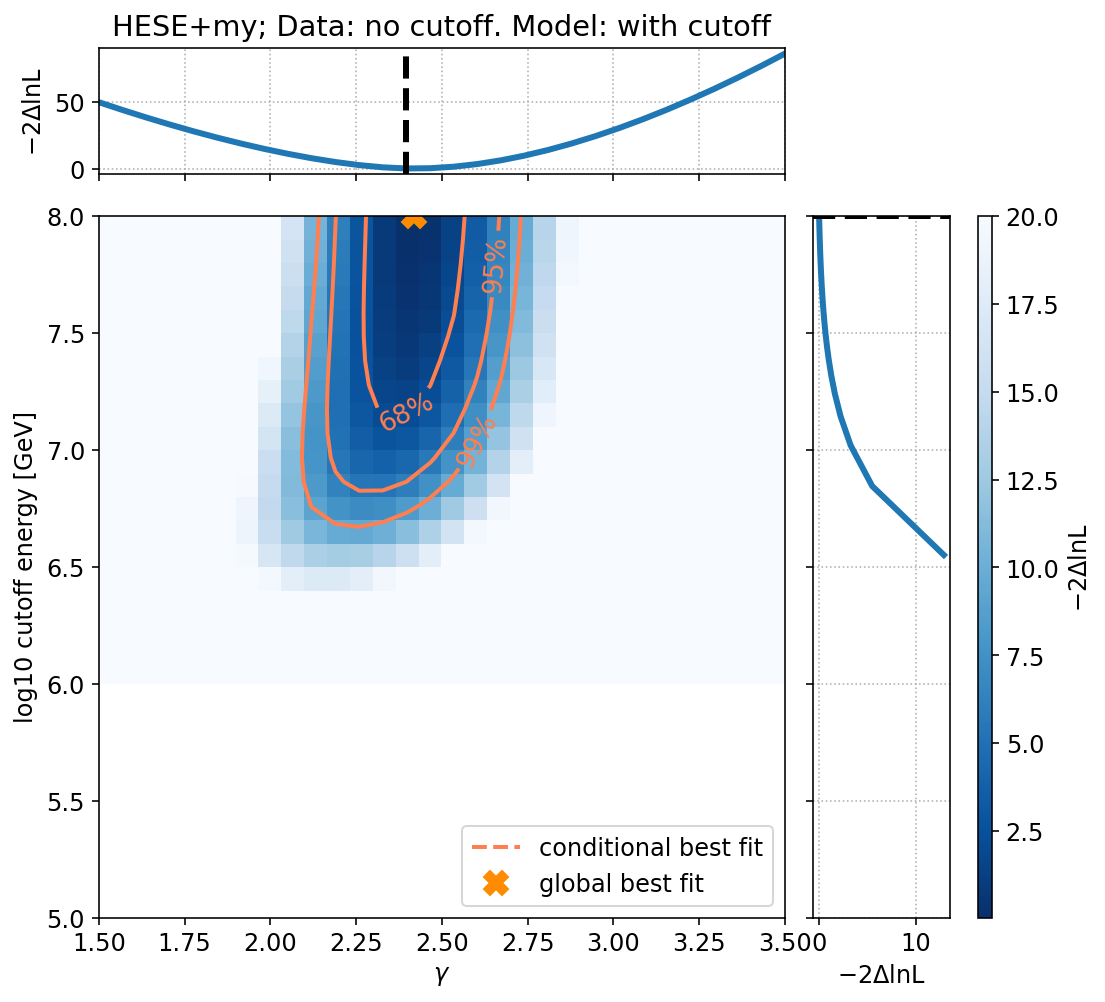

In [834]:
plt.figure(figsize=(8,8))

gspec = gridspec.GridSpec(2, 3,width_ratios=[5,1,0.1], height_ratios=[0.9,5], wspace=0.1, hspace=0.1)

ax1 = plt.subplot(gspec[0])

plt.plot(ggs,ggprof,lw=3)
plt.axvline(ggs[ggprof==np.min(ggprof)],ls='--',lw=3,color='black')
plt.xlim(1.5,3.5)
plt.ylabel(r'$-2\Delta$lnL')
plt.title('HESE+my; Data: no cutoff. Model: with cutoff')
ax1.tick_params(labelbottom=False)    
plt.grid(True,which='both',zorder=0,linestyle=':')

axbar = plt.subplot(gspec[5])

ax2 = plt.subplot(gspec[3])

h,yy,xx,img=plt.hist2d(gs,np.log10(cs),weights=t.clip(-np.inf,20),bins=[len(gammas),len(cutoffs)],range=[[1.5,3.5],[5,8]],cmap='Blues_r')#,norm=LogNorm())
plt.plot(gammas,best_cutoffs,'--',color='coral',lw=2,label='conditional best fit')
plt.plot(m.values[1],np.log10(m.values[2]),'X',color='darkorange',ms=12,label='global best fit')
cbar = plt.colorbar(cax=axbar)
cbar.set_label(r'$-2\Delta$lnL') 
CS=plt.contour(h.transpose(),extent=[np.min(gammas),np.max(gammas),np.min(np.log10(cutoffs)),np.max(np.log10(cutoffs))],levels=CL,colors='coral',linewidths=2)
plt.clabel(CS,fmt={CL[0]:'68%',CL[1]:'95%',CL[2]:'99%'},fontsize=13)
plt.legend(loc='lower right',prop={'size': 12})
plt.xlim(1.5,3.5)
plt.ylim(5,8)
plt.xlabel(r'$\gamma$')
plt.ylabel('log10 cutoff energy [GeV]')

ax3 = plt.subplot(gspec[4])

plt.plot(ccprof,np.log10(ccs),lw=3)
plt.axhline(np.log10(ccs[ccprof==np.min(ccprof)]),ls='--',lw=3,color='black')
ax3.tick_params(labelleft=False)
plt.ylim(5,8)
plt.xlabel(r'$-2\Delta$lnL')
plt.grid(True,which='both',zorder=0,linestyle=':')

plt.show()